In [1]:
! pip install scipy -U
! pip install pmdarima
! pip install fbprophet
! pip install hvplot
! pip install tsfresh
! pip install gluonts
! pip install mxnet

     |████████████████████████████████| 27.4MB 157kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 1.5MB 7.6MB/s 
     |████████████████████████████████| 9.5MB 19.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 3.1MB 6.7MB/s 
     |████████████████████████████████| 102kB 6.0MB/s 
     |████████████████████████████████| 706kB 13.1MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 1.1MB 15.2MB/s 
     |████████████████████████████████| 112kB 41.4MB/s 
     |████████████████████████████████| 1.3MB 38.8MB/s 
ERROR: googleapis-common-protos 1.53.0 has requirement protobuf>=3.12.0

     |████████████████████████████████| 901kB 6.8MB/s 
     |████████████████████████████████| 10.1MB 10.4MB/s 
     |████████████████████████████████| 46.9MB 80kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Sberbank stock price prediction models</h1>
</div>

I decided to use 3-year Sberbank stock prices from their official cite:

https://www.sberbank.com/ru/investor-relations/share-profile/stock-chart-and-performance-calculator

since Sberbank is a large company, I do not assume that there will be a large number of anomalies (such as with cryptocurrency), while the company is actively traded on the exchange, so predicting their quotes is a rather useful exercise

We will predict **Close** prices.

### Content:
1. Load the Data
  - Import libraries
  - Load the datasets
  
2. Overview of the Data
  - Descriptive Statistics
  - Missing Values

3. Exploratory Data Analysis and Data Preparation
  - Visualize the time series using line plot
  - Check distribution of the time series
  - Check monthly seasonality using multiple lines
  - Plot moving average and confidence intervals
  - Plot exponential smoothing
  - Plot double exponential smoothing
  - Holt-Winters exponential smoothing and detect anomalies
  - Check monthly seasonality and yearly trend using box plot
  - Decompose the time series
  - Stationarity test - Augmented Dickey Fuller test (ADH Test)
  - ACF-PACF plots and Find the order of differencing 
  
4. Model Building
  - Transform the data using box-cox transformation
  - Split data in train-test dataset
  - Model 1 - ARIMA
  - Model 2 - SARIMA
  - Model 3 - SARIMAX
  - Model 4 - Simple Exponential Smoothing
  - Model 5 - Holt-Winters
  - Define function to evaluate models
  - Train and evaluate the model
  - Save the model

5. Classic ML with feature engineering (normal or tsfresh)
  - usual ML model with default feature engineering
  - tsfresh feature engeneering

6. Prophet library

7. GluonTS (deep learning Amazon)

8. Manual Deep learning Model (LSTM)

9. Compare results

10. Usefull functions

## Inputs

In [1]:
# Input file name with path
input_file_name = 'https://github.com/serzaraisk/time_series-template/blob/794c83cc8a27df7410c1820b560f0938852485a2/Sberbank_3_years_stock_prices.csv?raw=true'

# Target class name
input_target_variable = 'Close'

# Date column name
input_date_variable = 'Date'

# Exogenous variable
input_exogenous_variable = ['Open', 'Max', 'Min']

## 1.Load data 

In this section we will:

- Import the libraries
- Load the dataset

### 1.1. Import Libraries

Import all the libraries in the first cell itself

In [2]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd
from   pandas import DataFrame
from pandas.plotting import lag_plot
import panel as pn 

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Statistics
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet

import tsfresh as ts

from dateutil.parser import parse 
import pickle

from scipy.optimize import minimize  # for function minimization
from tqdm import tqdm_notebook

# Set the options
sns.set()
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 120})

In [3]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 1.2. Load the datasets

Load the dataset using pd.read_csv()

In [5]:
# Read data in form of a csv file
df = pd.read_csv(input_file_name)

df[input_date_variable] = pd.to_datetime(df[input_date_variable], format='%d.%m.%Y')
df.sort_values(input_date_variable, inplace=True)

# First 5 rows of the dataset
df.head()

Date    Open     Max     Min   Close
0 2018-05-23  223.11  224.07  221.00  221.00
1 2018-05-24  221.91  223.70  221.12  222.01
2 2018-05-25  222.51  223.48  219.00  220.00
3 2018-05-28  219.47  221.50  219.20  220.90
4 2018-05-29  220.50  222.13  217.10  219.00

In [6]:
# also created monthly dataframe for smoothing some graphs
df_monthly = df.set_index('Date').resample('M').mean()
df_monthly

Open         Max         Min       Close
Date                                                      
2018-05-31  221.254286  222.968571  219.328571  220.897143
2018-06-30  211.859474  214.694211  209.244211  211.862105
2018-07-31  218.872727  221.613182  215.715000  218.818182
2018-08-31  192.213913  194.750435  187.917391  190.909130
2018-09-30  185.835500  189.224000  183.467000  186.576000
2018-10-31  190.241739  193.043913  186.627826  189.655217
2018-11-30  195.976667  198.512857  193.294286  196.070952
2018-12-31  189.352381  191.160952  187.210000  189.240952
2019-01-31  202.364000  204.954000  201.050000  203.583000
2019-02-28  210.141500  212.061000  207.656500  209.689000
2019-03-31  208.059500  209.875500  206.566000  208.238500
2019-04-30  230.979091  233.401364  228.492273  230.880909
2019-05-31  230.201429  232.906190  228.166667  230.749048
2019-06-30  239.679474  242.715789  237.417368  240.518421
2019-07-31  237.456957  239.078696  235.220870  236.998261
2019-08-31  220.971364  222.802727  218.576364  220.411364
2019-09-30  230.796667  232.315714  228.936667  230.752857
2019-10-31  232.121739  234.060870  230.246957  232.320435
2019-11-30  237.995000  239.538500  236.122500  237.942000
2019-12-31  241.158571  243.123333  239.769048  241.853333
2020-01-31  259.781500  262.075500  257.354500  259.728500
2020-02-29  251.097895  253.102105  248.548421  250.596842
2020-03-31  199.654286  204.947619  192.291429  198.319524
2020-04-30  192.224545  194.798636  189.585909  192.443636
2020-05-31  192.861579  195.116842  190.874211  192.855789
2020-06-30  209.529500  212.209000  206.838500  209.714000
2020-07-31  212.896364  215.160909  210.427273  213.613182
2020-08-31  231.109130  233.540870  228.342174  230.950870
2020-09-30  225.599667  227.588000  223.059000  225.503667
2020-10-31  208.485806  210.212581  205.872581  207.799032
2020-11-30  234.355517  237.795862  231.701379  235.958621
2020-12-31  271.939667  275.329333  268.951000  272.688333
2021-01-31  275.553704  278.994815  271.001481  274.442593
2021-02-28  268.483462  271.483462  265.501538  269.323462
2021-03-31  283.976667  287.415667  281.156000  284.835667
2021-04-30  289.034333  291.216000  286.587333  289.213667
2021-05-31  304.082105  306.658947  300.938947  304.504211

## 2.Overview of the Data</h2>

In this section we will:
- Get the descriptive statistics of the data
- Get the information about missing values in the data

### 2.1. Descriptive Statistics

As the name says descriptive statistics describes the data. It gives you information about
- Mean, median, mode 
- Min, max
- Count etc

Let's understand the data we have

In [7]:
# Dimension of the data
df.shape

(826, 5)

In [8]:
# Summary of the dataset
df.describe(datetime_is_numeric=True)

Date        Open         Max         Min  \
count                            826  826.000000  826.000000  826.000000   
mean   2019-12-25 17:43:26.295412224  230.053692  232.578547  227.361550   
min              2018-05-23 00:00:00  170.200000  172.670000  165.900000   
25%              2019-03-18 06:00:00  205.455000  207.855000  203.297500   
50%              2020-01-11 12:00:00  227.160000  229.130000  225.050000   
75%              2020-10-15 18:00:00  248.312500  250.302500  246.427500   
max              2021-05-23 00:00:00  316.000000  319.160000  315.480000   
std                              NaN   31.887193   31.909088   31.864101   

            Close  
count  826.000000  
mean   230.130581  
min    169.360000  
25%    205.425000  
50%    227.165000  
75%    248.950000  
max    317.940000  
std     32.010152

### 2.2. Missing Values

Get the info about missing values in the dataframe

In [9]:
# Missing values for every column
df.isna().sum()

Date     0
Open     0
Max      0
Min      0
Close    0
dtype: int64

__Step's conclusion__

Dataset doesn't contain any missing values, so we don't need any preprocessing steps.

## 3.Exploratory Data Analaysis</h2>

Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns in the data. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

In this section we will:
  - Visualize the time series using line plot
  - Check distribution of the time series
  - Check monthly seasonality using multiple lines
  - Plot moving average and confidence intervals
  - Plot exponential smoothing
  - Plot double exponential smoothing
  - Holt-Winters exponential smoothing and detect anomalies
  - Check monthly seasonality and yearly trend using box plot
  - Decompose the time series
  - Stationarity test - Augmented Dickey Fuller test (ADH Test)
  - ACF-PACF plots and Find the order of differencing 

### 3.1. Visualize the time series using line plot

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:
- Whether the trend appears to be level around the mean
- Whether there appear to be any obvious outliers

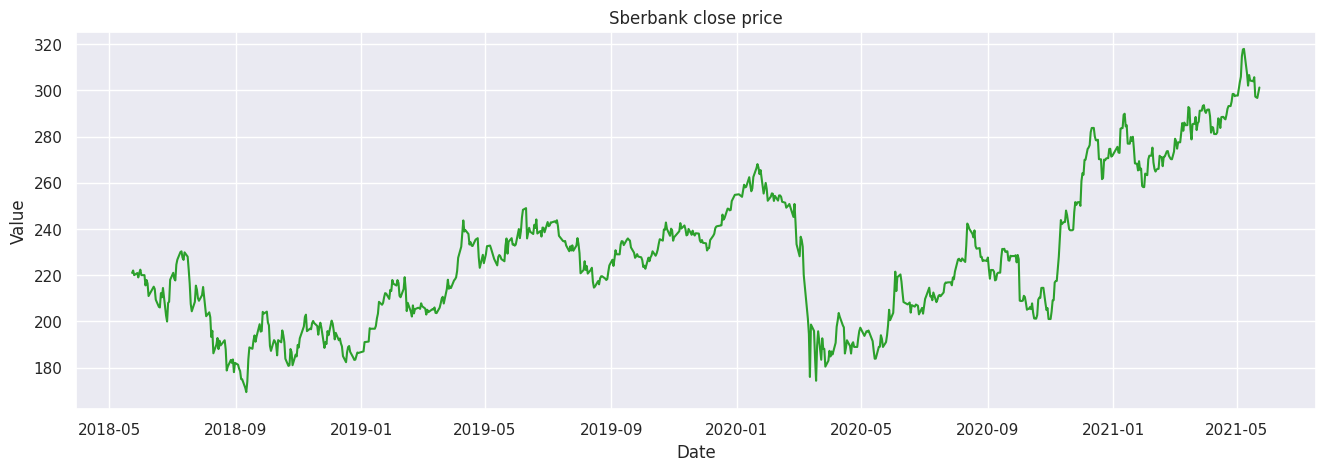

In [10]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:green')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df[input_date_variable], y=df[input_target_variable], title='Sberbank close price')

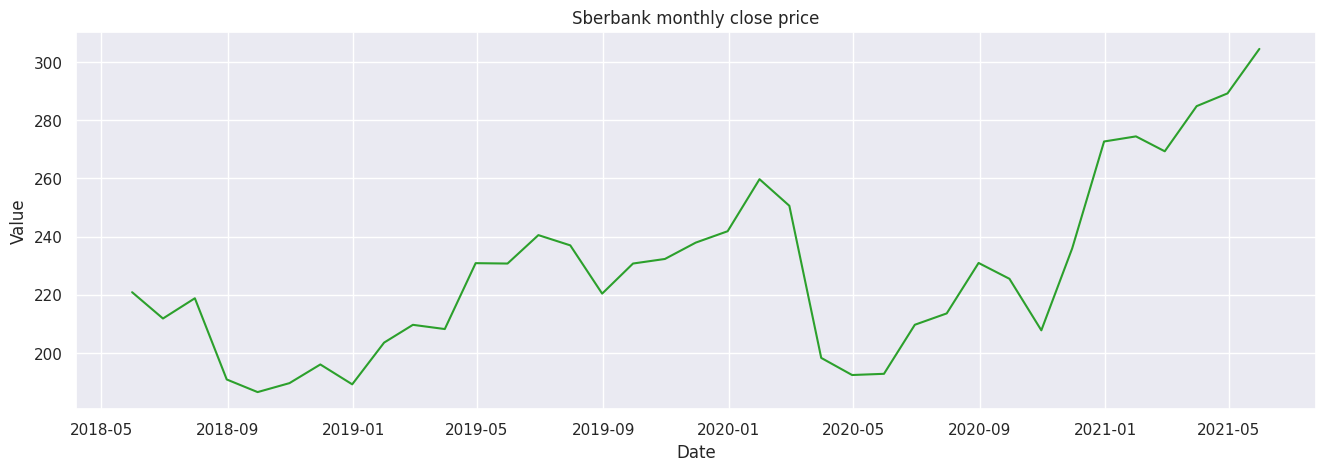

In [11]:
plot_df(x=df_monthly.index, y=df_monthly[input_target_variable], title='Sberbank monthly close price')

__Step's coclusion__

For Sberbank shares, you can see:
- clearly increasing trend
- seasonality is not visible on the current graph
- In February-March, some kind of anomaly clearly occurred, which greatly lowered the price of Sberbank shares.

### 3.2. Check distribution of the time series

We should check the distribution of the time series so that you can decide if you need to transform the data or can be used as it is. Additionally, it provides insights about the type of distribution the data follows

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



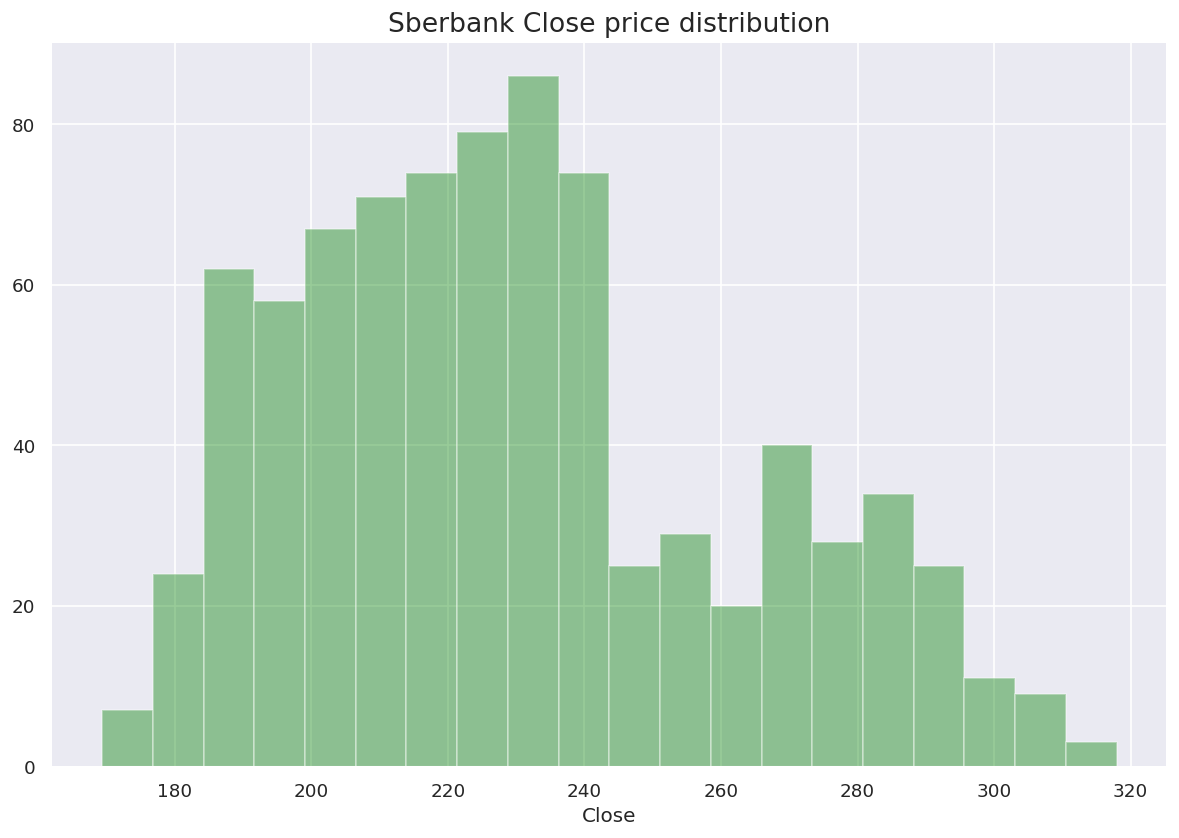

In [12]:
sns.distplot(df[input_target_variable], kde = False, color ='green', bins = 20)
plt.title('Sberbank Close price distribution', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



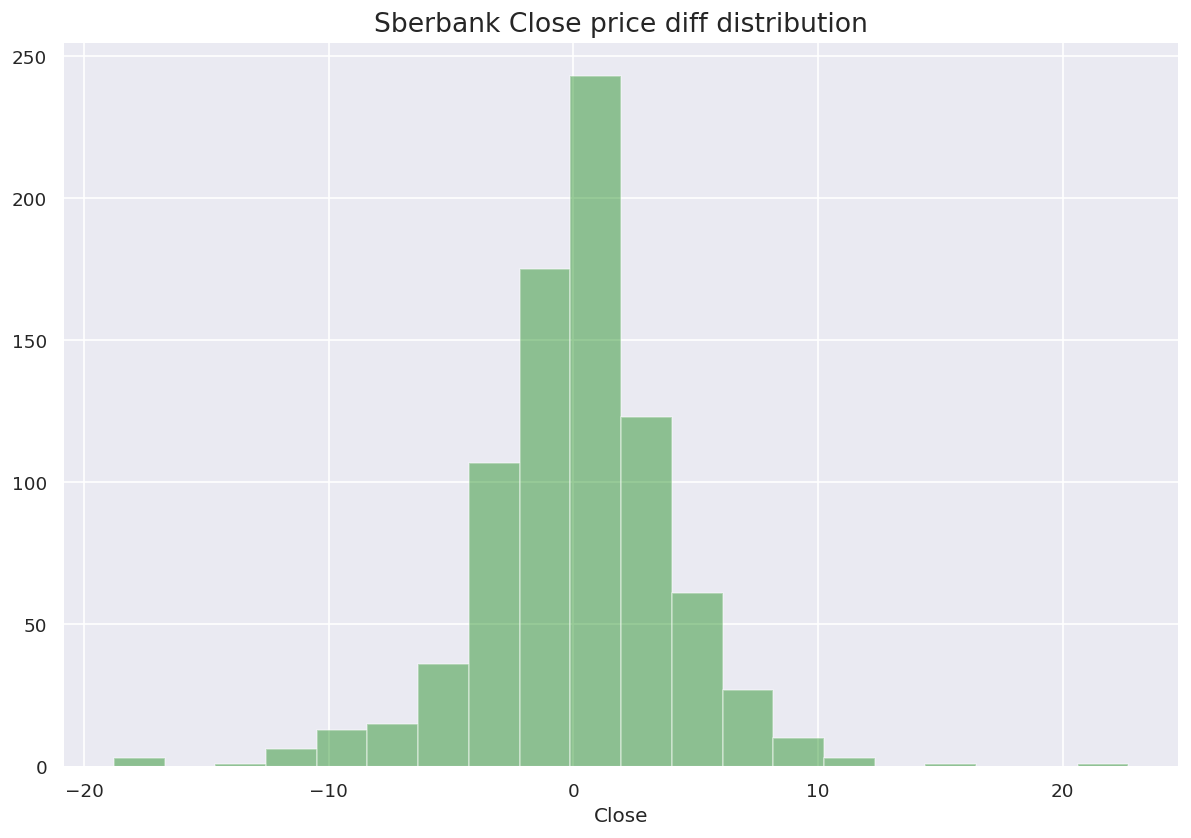

In [13]:
sns.distplot(df[input_target_variable].diff(), kde = False, color ='green', bins = 20)
plt.title('Sberbank Close price diff distribution', fontsize=16)
plt.show()

__Step's coclusion__

According to the distribution graph of the closing price, it can be seen that the graph is scewed to the right, which is logical, since the price began to rise above the average (240) only in the 2021.

Price Differences has normal distribution, with some outliers on the left. 

### 3.3. Check monthly seasonality using multiple lines

In [14]:
def plot_timeseries_divided(df, target_series_name, devided_series_name,  x_series_name, title):

    periods = df[devided_series_name].unique()

    # Prep Colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(periods), replace=False)

    # Draw Plot
    plt.figure(figsize=(16,8), dpi= 80)
    for i, y in enumerate(periods):
        if i> 0:
            plt.plot(x_series_name, target_series_name, data=df.loc[df[devided_series_name]==y, :], color=mycolors[i], label=y)
            plt.text(df.loc[df[devided_series_name]==y, :].shape[0]-.9, df.loc[df[devided_series_name]==y, target_series_name][-1:].values[0], y, fontsize=12, color=mycolors[i])

    # Decoration
    plt.gca().set(ylabel=target_series_name, xlabel=x_series_name)
    num_ticks=len(df[x_series_name].unique())
    plt.yticks(fontsize=10, alpha=.7)
    plt.title(title, fontsize=20)
    plt.show()

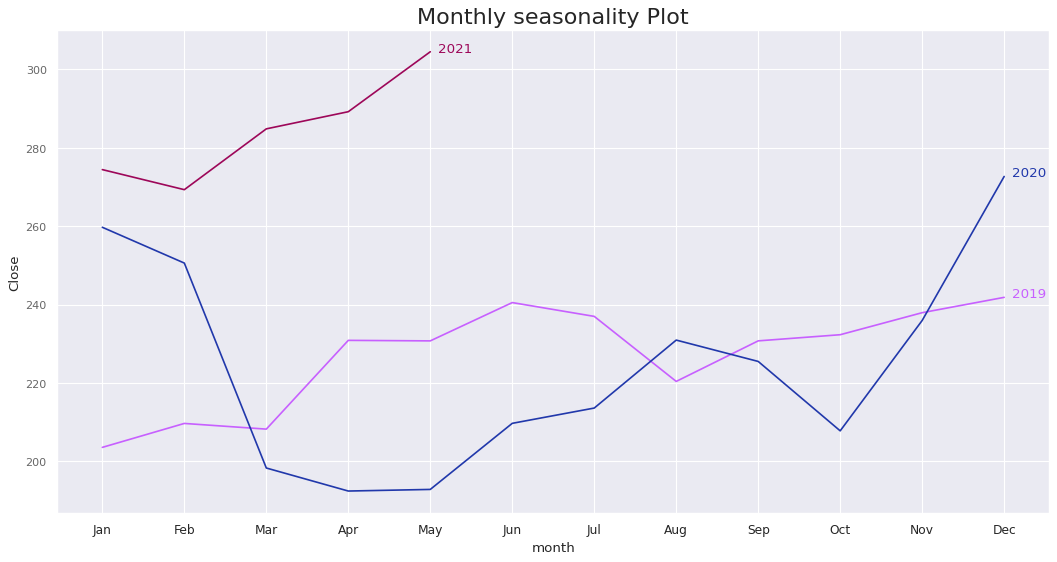

In [15]:
df_monthly.reset_index(inplace=True)
df_monthly['year'] = [d.year for d in df_monthly[input_date_variable]]
df_monthly['month'] = [d.strftime('%b') for d in df_monthly[input_date_variable]]
plot_timeseries_divided(df_monthly, input_target_variable, 'year', 'month', 'Monthly seasonality Plot')

__Step's coclusion__

Again, we can't see any monthly seasonality in the plot.

The beggining of the 2021 can be compared with the shifted version of the 2019

### 3.4. Plot moving average with confidence intervals

In [16]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


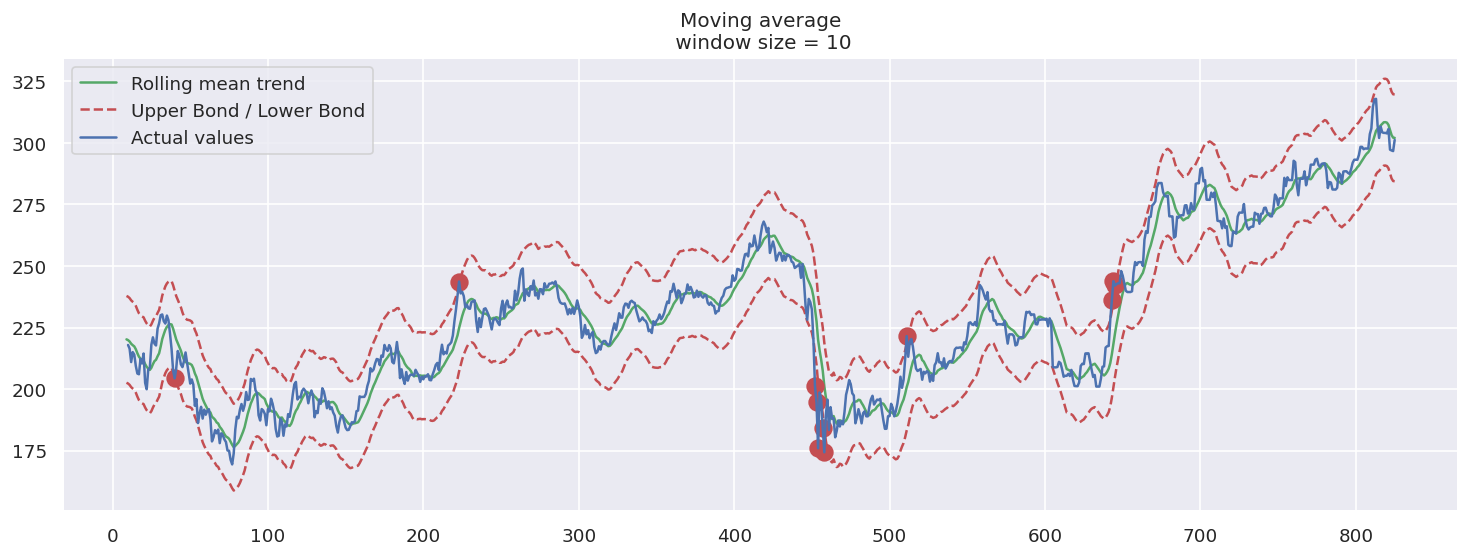

In [17]:
plotMovingAverage(df[[input_target_variable]], 10, plot_intervals=True, plot_anomalies=True)

__Step's coclusion__

Moving average was able to capture general trend of the time series: As we can see, there are 7-8 anomalies, which goes beyond 3 confidence intervals

### 3.5. Plot exponential smoothing 


$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function – we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [18]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [19]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "green", label = "Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

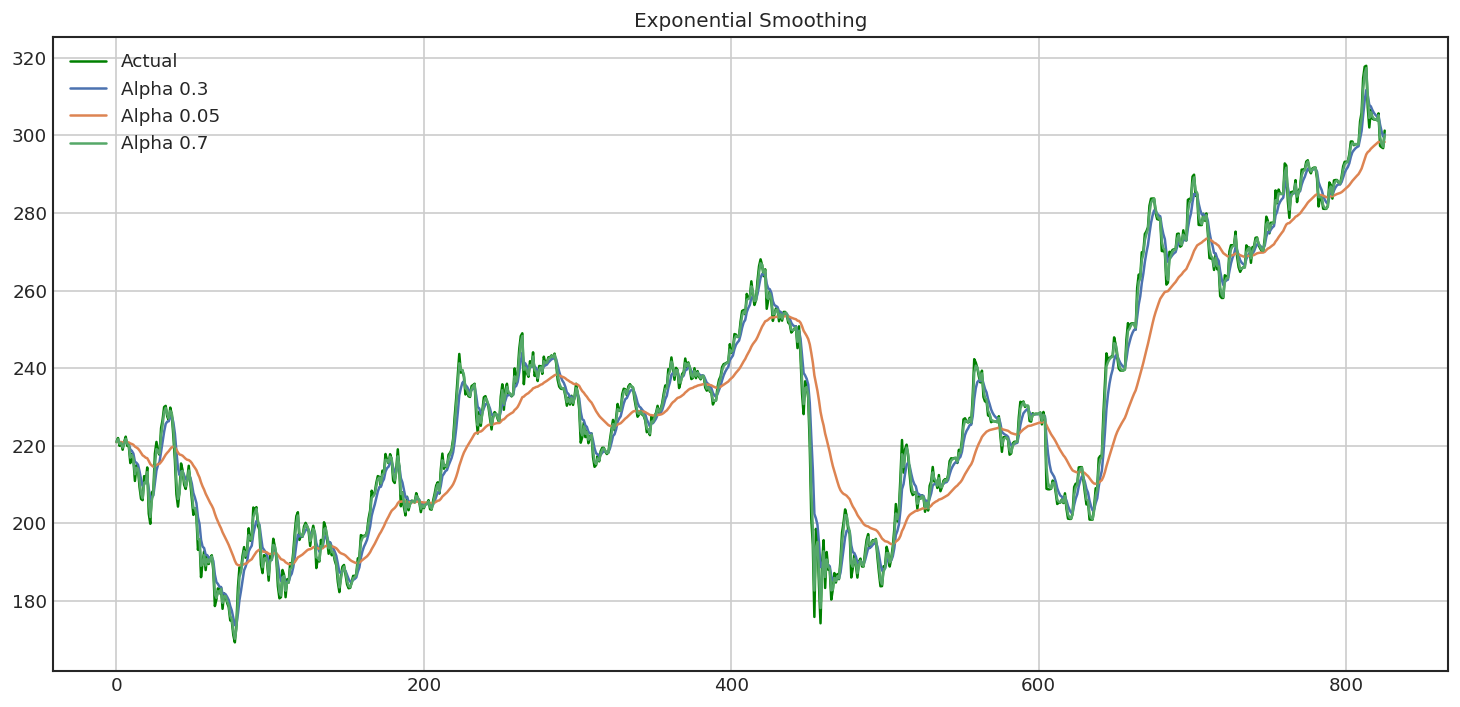

In [20]:
plotExponentialSmoothing(df[input_target_variable], [0.3, 0.05, 0.7])

__Step's coclusion__

Exponential smoothing  was also able to capture general trend of the time series: Small alpha obviously doesn't catch up flucluations, so It's seems that bigger alpha, like 0.3 and 0.7 gives better results.

### 3.8. Plot double exponential smooting

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [21]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(
                    double_exponential_smoothing(series, alpha, beta),
                    label="Alpha {}, beta {}".format(alpha, beta),
                )
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

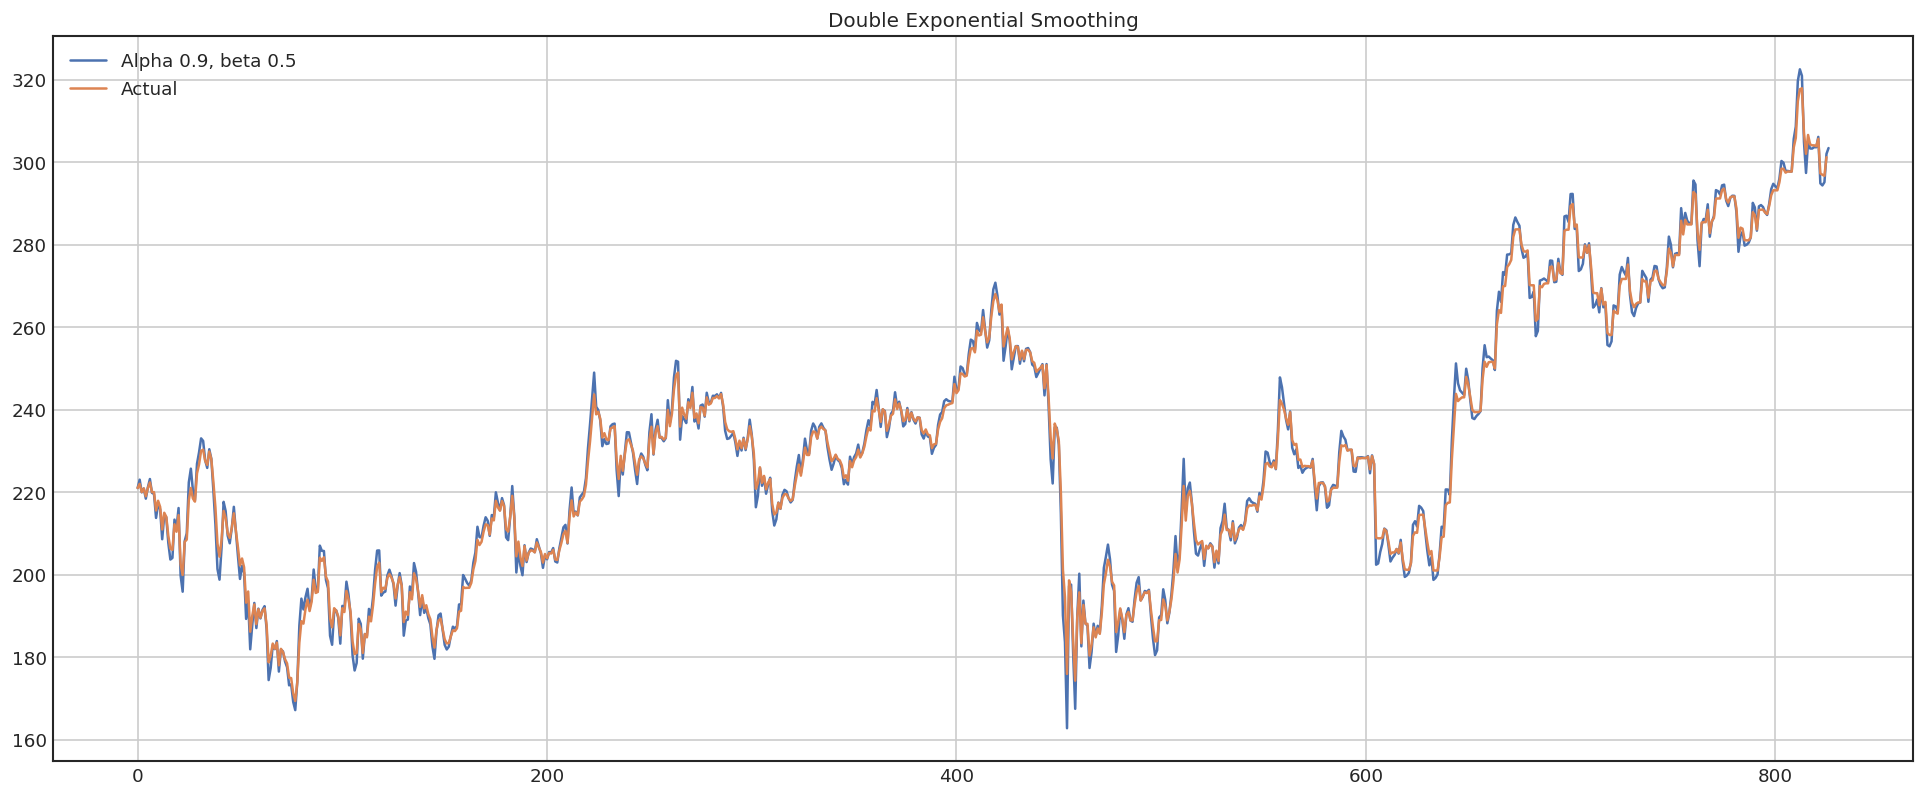

In [22]:
plotDoubleExponentialSmoothing(df[input_target_variable], alphas=[0.9], betas=[0.5])

__Step's coclusion__

It can be seen that exponential smoothing was able to repeat the original chart of stock prices: you can see from the chart that smoothing is wrong only in abnormally strong drawdowns

### 3.9. Holt-Winters triple exponential smoothing and detect anomalies

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. 

In [22]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [23]:
from sklearn.model_selection import \
    TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [24]:
%%time
data = df[input_target_variable][:-10]  

opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_log_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(
    data,
    slen=12,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=20,
    scaling_factor=3,
)
model.triple_exponential_smoothing()

NameError: ignored

In [25]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [26]:
plotHoltWinters(df[input_target_variable], plot_intervals=True, plot_anomalies=True)

NameError: ignored

<Figure size 2400x1200 with 0 Axes>

In [27]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

NameError: ignored

<Figure size 3000x600 with 0 Axes>

__Step's coclusion__

### 3.10. Seasonality and Yearly Trend using Box Plot

You can check the yearly trend and monthly seasonality using a box plot.

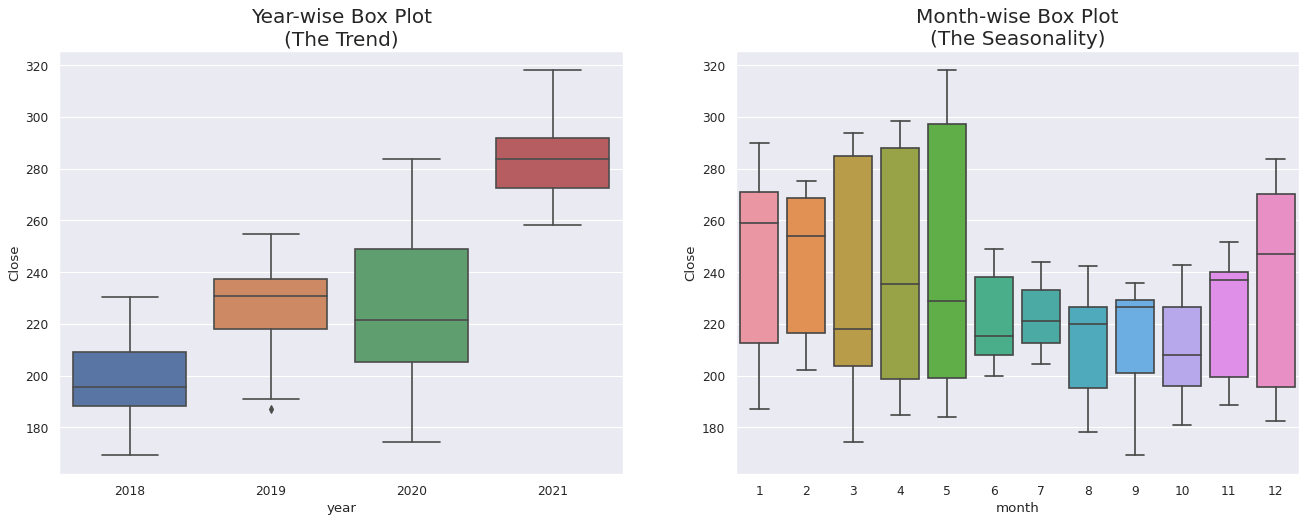

In [23]:
# Draw Plot
df['month'] = df[input_date_variable].dt.month
df['year'] = df[input_date_variable].dt.year
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=input_target_variable, data=df, ax=axes[0])
sns.boxplot(x='month', y=input_target_variable, data=df)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

__Step's coclusion__

On the graphs we see:
1. Additional confirmation of the increasing trend
2. The largest price deviation was in 2020
3. In terms of months, the largest deviation occurs in the first half of the year and the last month of the year, in the second half of the year the price is quite stable

### 3.11. Time Series Decomposition

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

Additive time series:
- Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
- Value = Base Level x Trend x Seasonality x Error

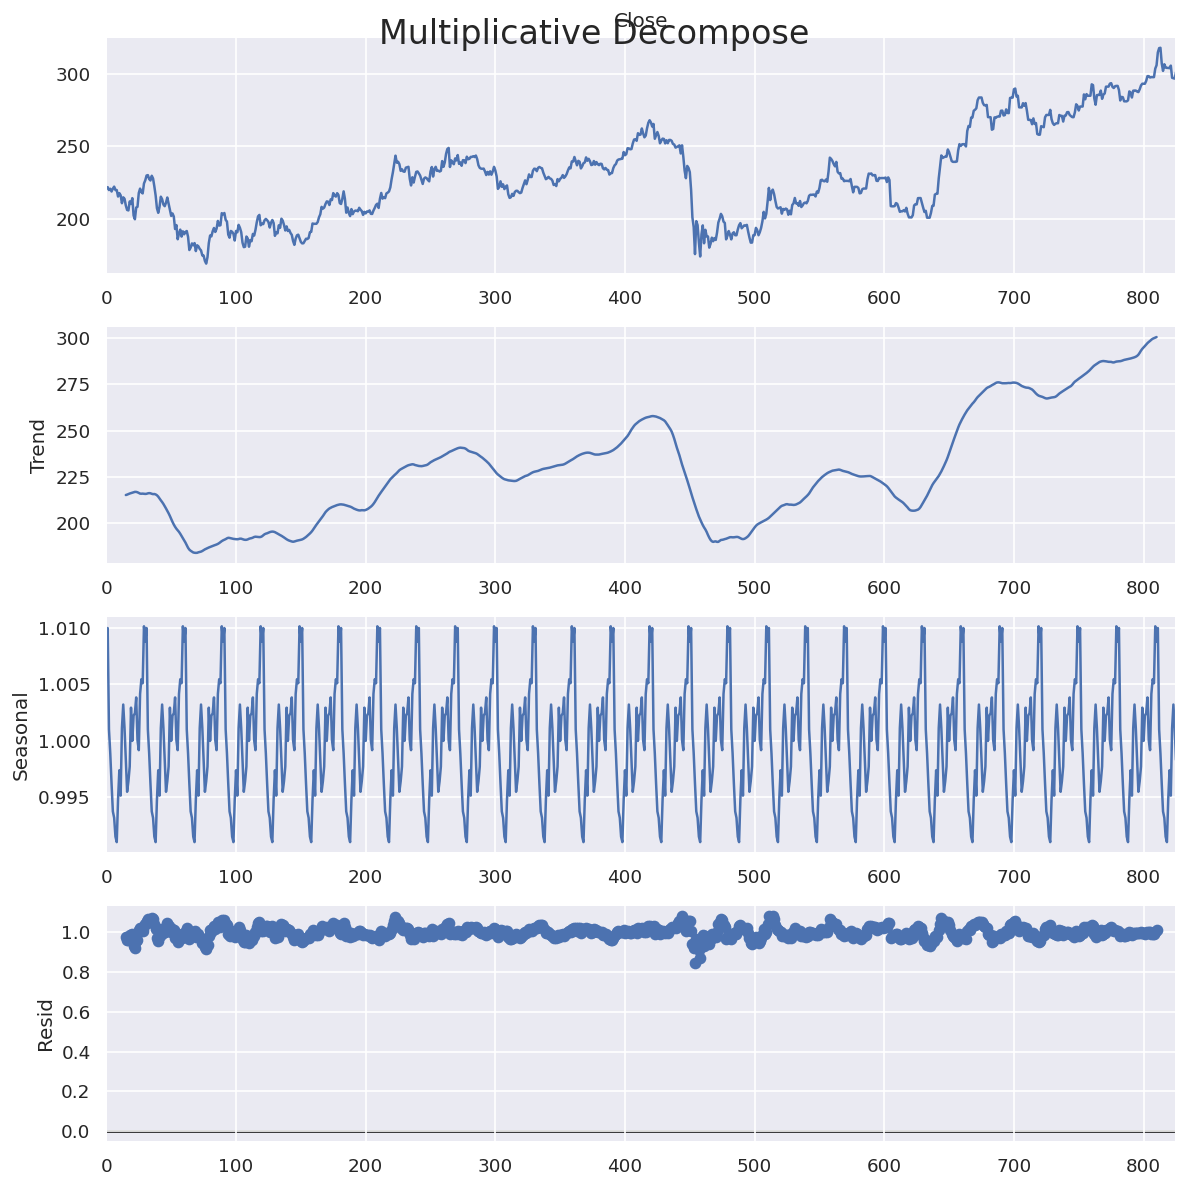

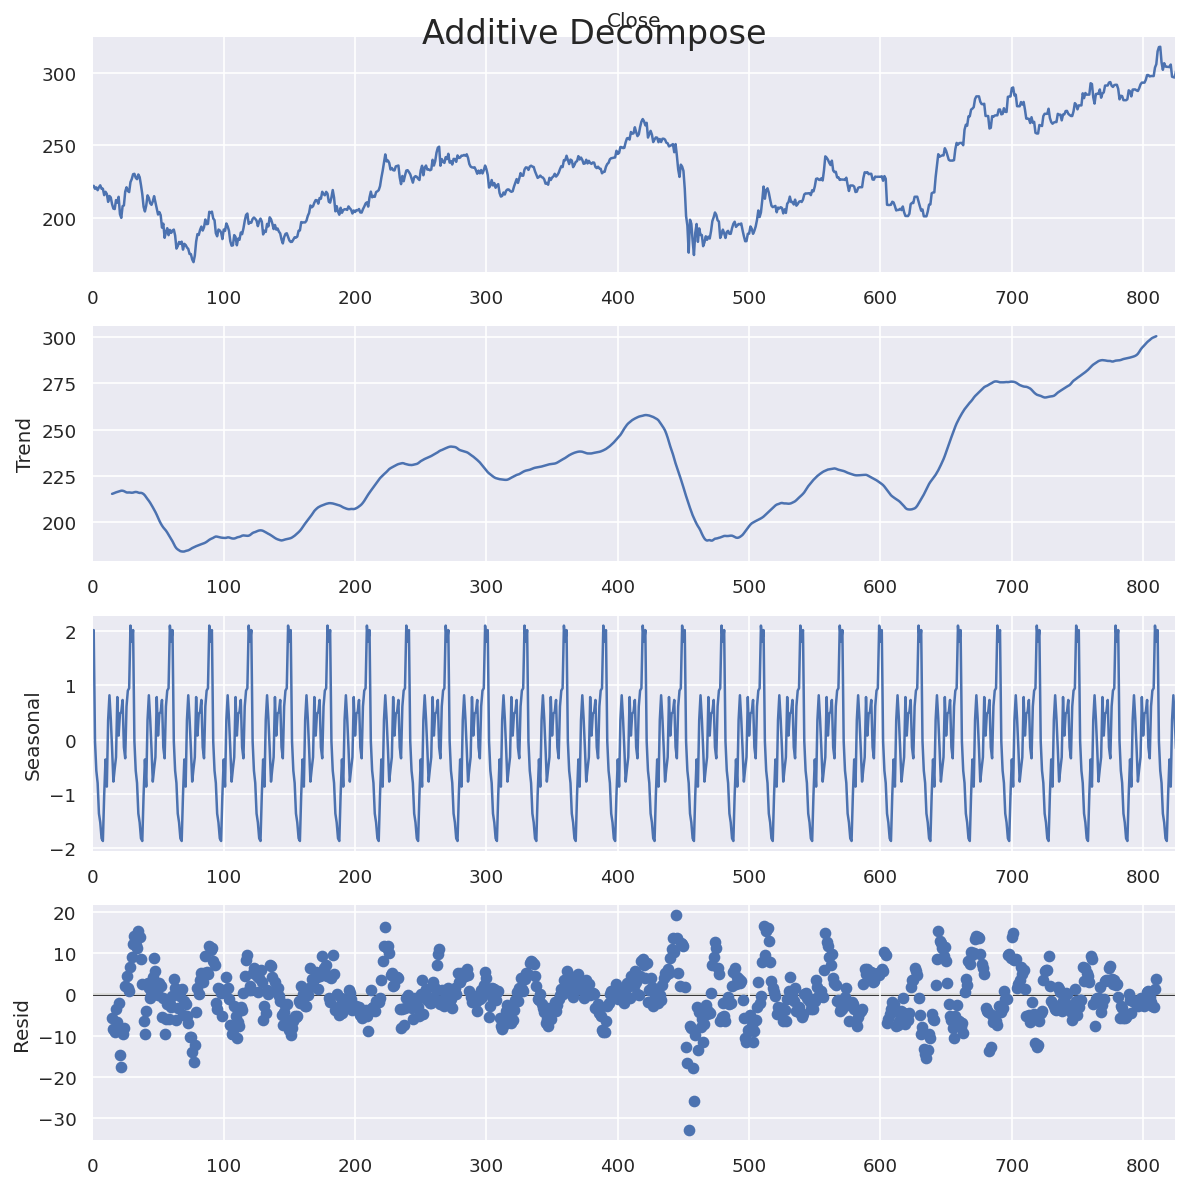

In [24]:
# Multiplicative Decomposition 
input_seasonality = 30
result_mul = seasonal_decompose(df[input_target_variable], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target_variable], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.show()

__Step's coclusion__

Both decompositions cannot highlight seasonality in the charts (errors are greater than seasonality). The multiplicative model looks more stable.

### 3.12 Stationarity test - Augmented Dickey Fuller test (ADH Test)

There are mulitple tests to test if a time series is stationary or not.

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [25]:
# ADF Test
result = adfuller(df[input_target_variable].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.0835458530404145
p-value: 0.721588827536342
Critial Values:
   1%, -3.438399099271788
Critial Values:
   5%, -2.8650928286782857
Critial Values:
   10%, -2.568661836350634


In [26]:
# KPSS Test
result = kpss(df[input_target_variable].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.911091
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




__Step's coclusion__

Since our data have a pronounced trend, it is obvious that both methods showed that the series is not stationary.

### 3.13. ACF-PACF plots and Find the order of differencing 

**How to find the order of differencing?**

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

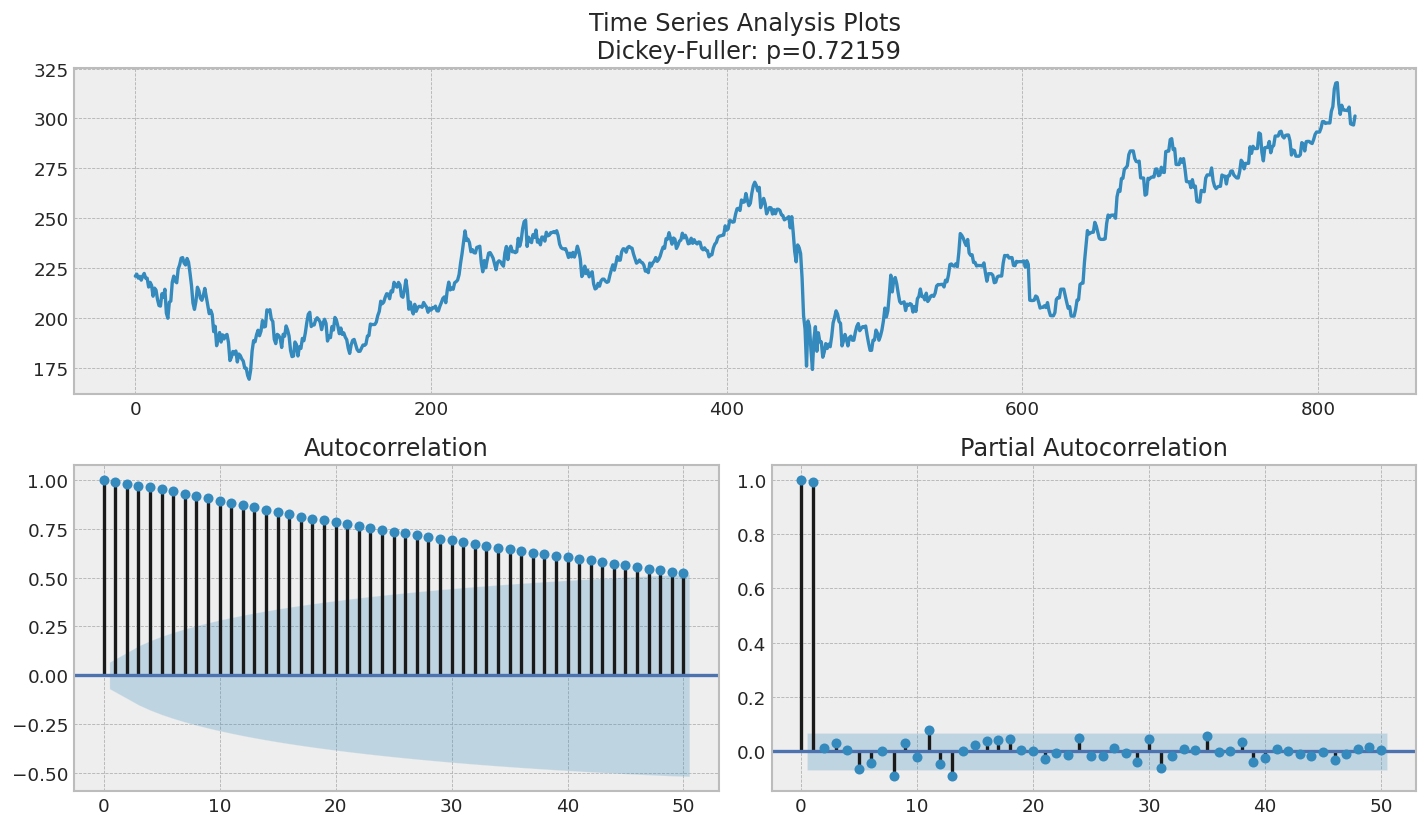

In [28]:
tsplot(df[input_target_variable], lags=50)

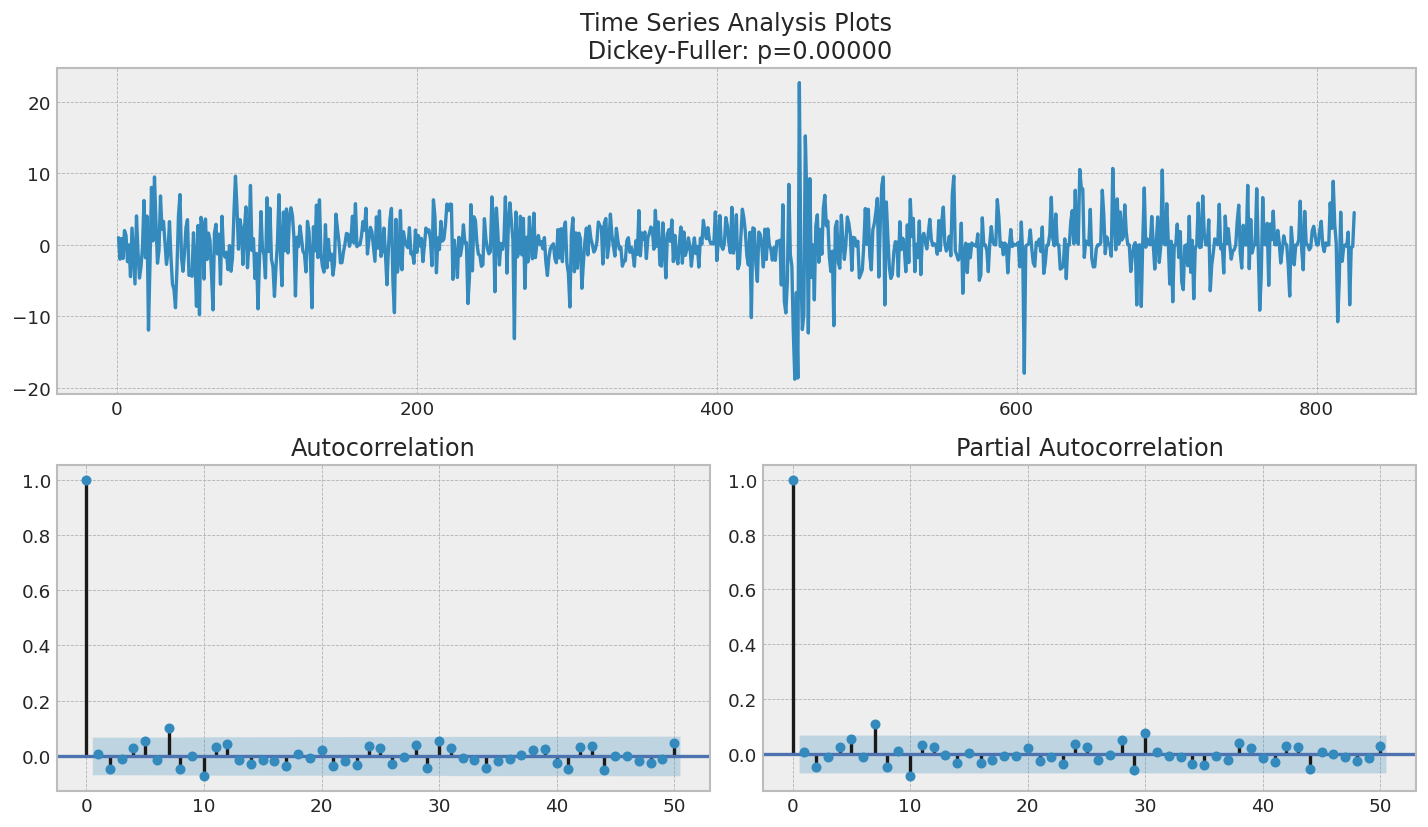

In [29]:
tsplot(df[input_target_variable].diff().dropna(), lags=50)

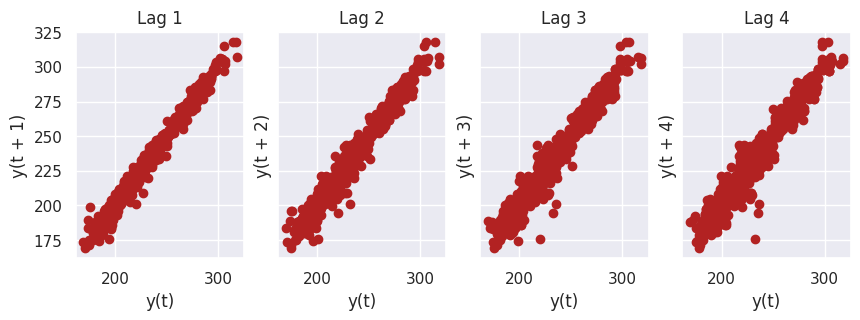

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df[input_target_variable], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

In [31]:
## Adf Test
print('Adf Test: ', ndiffs(df[input_target_variable], test='adf'))
# KPSS test
print('KPSS test: ', ndiffs(df[input_target_variable], test='kpss')) 
# PP test:
print('PP test: ', ndiffs(df[input_target_variable], test='pp'))

Adf Test:  1
KPSS test:  1
PP test:  1


If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

__Step's coclusion__

To transform a series into a stationary one, one differentiation is required. The partial autocorrelation plots clearly show that lag 1 is very strongly correlated with the current price (that is, the stock price today is largely determined by the stock price today).

## 4.Model Building

In this section we will:
- Split data in train-test dataset
- Model 1 - ARIMA
- Model 2 - SARIMA
- Model 3 - SARIMAX
- Model 4 - Simple Exponential Smoothing
- Model 5 - Holt-Winters
- Define function to evaluate models
- Train and evaluate the model
- Save the model

### 4.2. Train - Test Window Split

For testing puproses we will take last 2 months.

Also we will train only on one last year, as Sberbank share prices had drastically descrease in the beginning of 2020 year, which looks like anomaly.

In [32]:
train, test = df[(df[input_date_variable] < '2021-04-01') & (df[input_date_variable] > '2020-04-01')], df[df[input_date_variable] >= '2021-04-01']

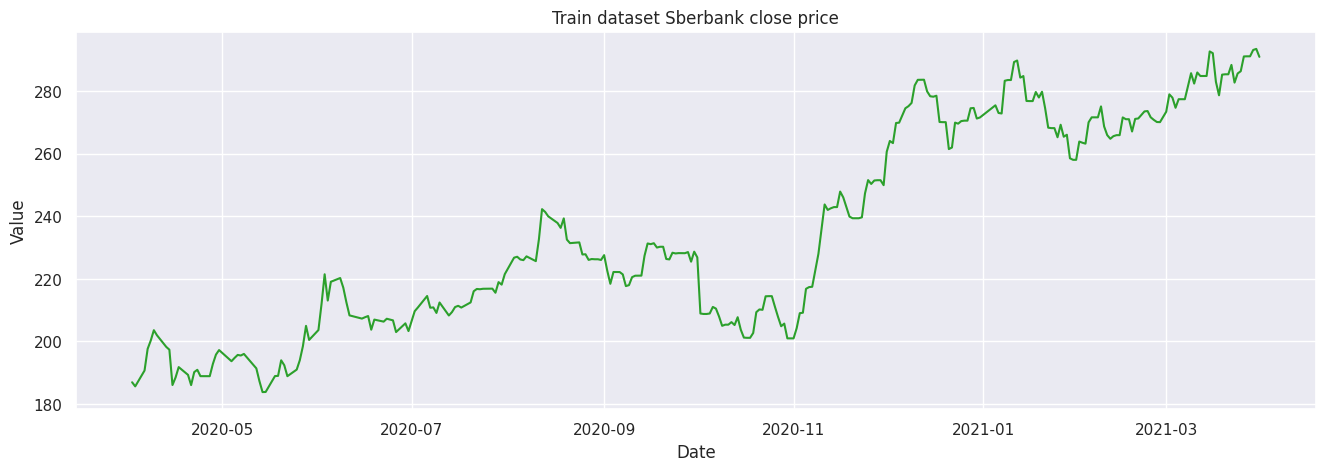

In [33]:
plot_df(x=train[input_date_variable], y=train[input_target_variable], title='Train dataset Sberbank close price')

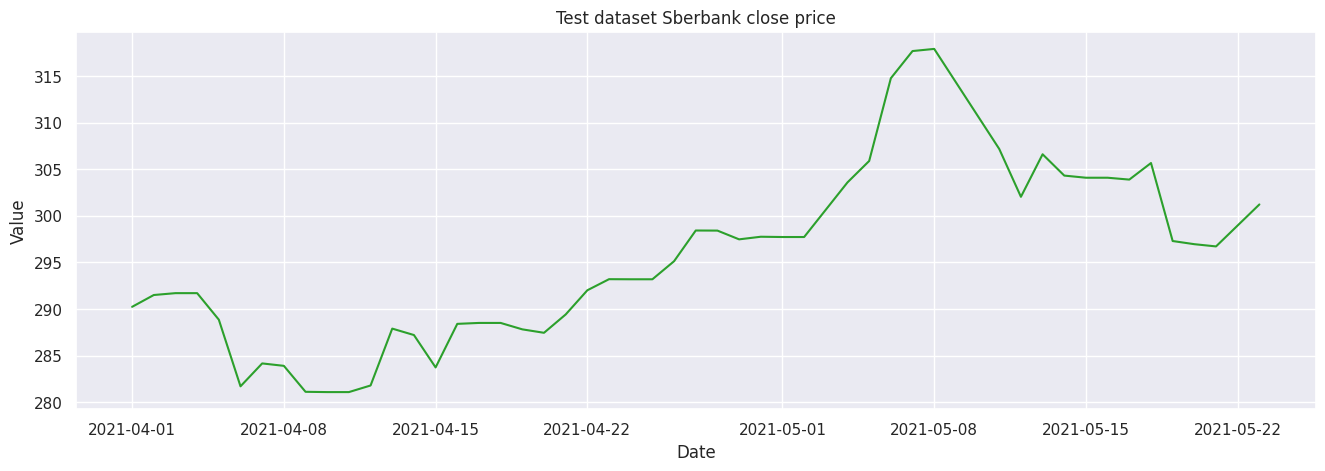

In [34]:
plot_df(x=test[input_date_variable], y=test[input_target_variable], title='Test dataset Sberbank close price')

In [35]:
print('Train shape:', train.shape )
print('Test shape:', test.shape)

Train shape: (308, 7)
Test shape: (49, 7)


### 4.3. Model 1 - ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The initial order of the ARIMA model can be determined using the the ACF and PACF plots. The initial starting point for 'p' is the number of significant lags from the PACF plot and 'q' comes from the number of significant lags from the ACF plot.

### 4.4. Model 2 - SARIMA

If a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

### 4.5. Model 3 - SARIMAX

If a time series has seasonal patterns and an external predictor (also called as exogenous variable), then you need to add seasonal and exogenous terms and it becomes SARIMAX

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

Since ARIMA, SARIMA are from the same family, I have defined a single function to fit these models automatically.

Sarimax won't be used as all columns which we will have has some kind of data leakage, as we can't know all open, min and max prices at the start of the forecasting.

All these models can be trained in pm.autoarima function

In [36]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target_variable], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 5, max_q = 5, m = input_seasonality, 
                          start_P = 0, seasonal = True, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = False, 
                          max_order=5)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

### 4.6. Model 4 - Simple Exponential Smoothing

Single Exponential Smoothing is a time series forecasting algorithm for univariate data which doesn't have a trend or seasonality. Only one parameter is required for SES - alpha (a).  It is the smoothing coefficient.

In [37]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.3,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.6. Model 5 - Double Exponential Smoothing

Double Exponential Smoothing is a time series forecasting algorithm for univariate data which have a trend and doesn't have seasonality.

In [38]:
def model_double_exponential_smoothing(y, type_='add'):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y), trend=type_).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.7. Model 6 - Holt-Winters

Holt-Winters is a time series forecasting algorithm. It models three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

You need to pass on the parameter seasonality to it

In [39]:
def model_holt_winters(y, seasonality, type_='add'):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend=type_, seasonal=type_).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.8. Define function to get the predictions

In [40]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

__Step's coclusion__

### 4.9. Define function to evaluate models

- Durbin Watson Statistic
- MAPE
- MAE
- RSME
- R2 Score

In [41]:
def durbin_watson_stat(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    return(durbin_watson(validation_df.error))

In [42]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [56]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))
    print("Durbin Watson Score : ", durbin_watson_stat(actuals, predictions))
    
    analyse_error(actuals, predictions)
    
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)
    return {'MAPE': mean_absolute_percentage_error(actuals, predictions),
            'RMSE': mean_squared_error(actuals, predictions, squared=False),
            'MAE': mean_absolute_error(actuals, predictions),
            'R2 Score': r2_score(actuals, predictions),
            'Durbin Watson Score': durbin_watson_stat(actuals, predictions)}

__Step's coclusion__

### 4.10. Train and evaluate the model

In [59]:
# Get actual values
def train_and_evaluate_model(input_ts_algo, type_='add'):
    print(input_ts_algo)
    actuals = test[input_target_variable].reset_index(drop = True)

    # Select the algorithm according to the input provided
    if input_ts_algo == 'auto_arima':
        
        print("------------- Auto ARIMA --------------- \n")
        model = model_auto_sarimax(y = train[input_target_variable], seasonality = None, seasonal_flag = False, exogenous_variable = None)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
        results = evaluate_model(actuals, predictions)
        
    elif input_ts_algo == 'auto_sarima':
        
        print("------------- Auto SARIMA --------------- \n")
        model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)
        
    elif input_ts_algo == 'auto_sarimax':
        
        print("------------- Auto SARIMAX --------------- \n")
        model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = train[input_exogenous_variable].values)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = test[input_exogenous_variable].values)
        results = evaluate_model(actuals, predictions)

    elif input_ts_algo == 'simple_exponential_smoothing':
        
        print("------------- Simple Exponential Smoothing --------------- \n")
        model = model_simple_exponential_smoothing(y = train[input_target_variable])
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)

    elif input_ts_algo == 'double_exponential_smoothing':
        
        print("------------- double_exponential_smoothing --------------- \n")
        model = model_double_exponential_smoothing(y = train[input_target_variable], type_=type_)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)
        
    elif input_ts_algo == 'holt_winters':
        
        print("------------- Holt Winters --------------- \n")
        model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality, type_=type_)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)
    return results

auto_arima
------------- Auto ARIMA --------------- 

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1664.897, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1665.717, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1667.215, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1667.854, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1669.710, Time=0.22 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1670.791, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1665.808, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1666.902, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1668.820, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1669.796, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1671.276, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1667.421, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1668.795, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[1] int

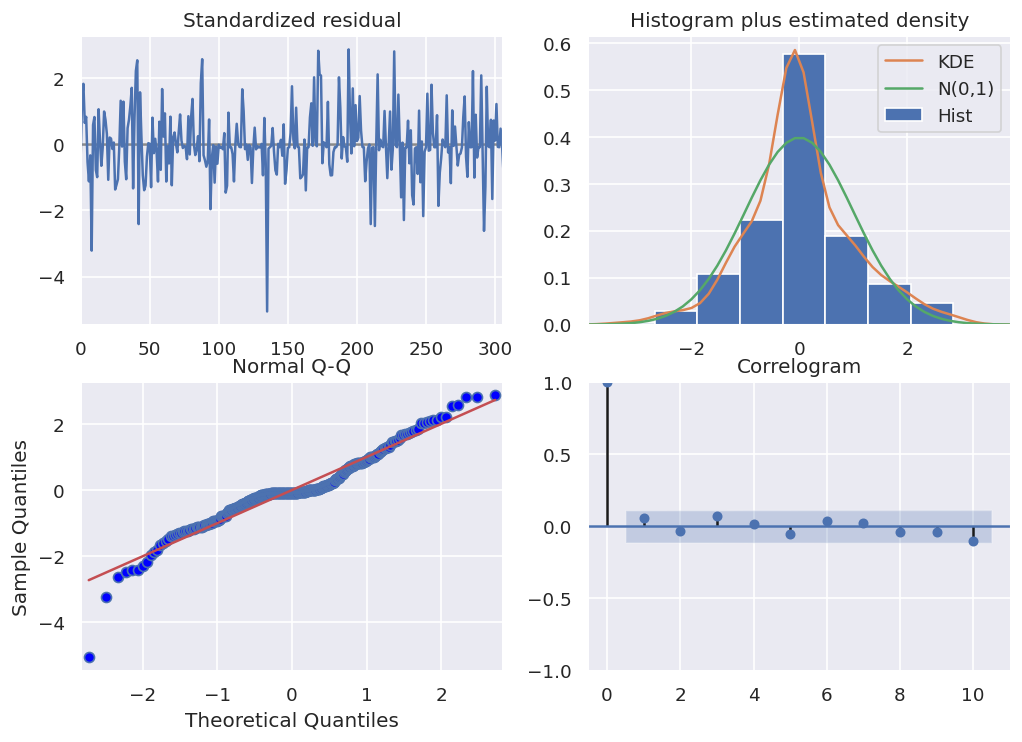

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  2.2033105847303913
MAE  :  6.450290500564778
RMSE  :  7.8142148307673
R2 Score  :  0.30453820845776236
Durbin Watson Score :  0.18819779870021938


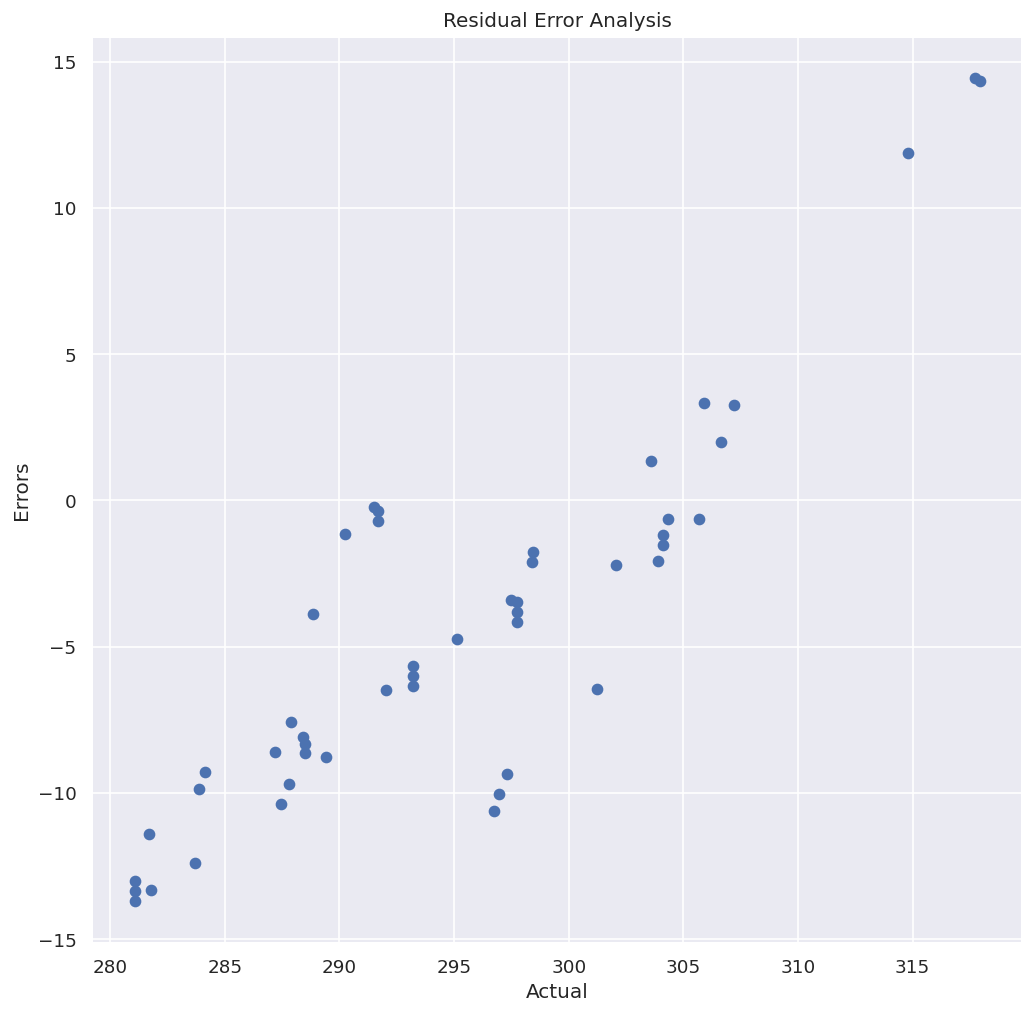

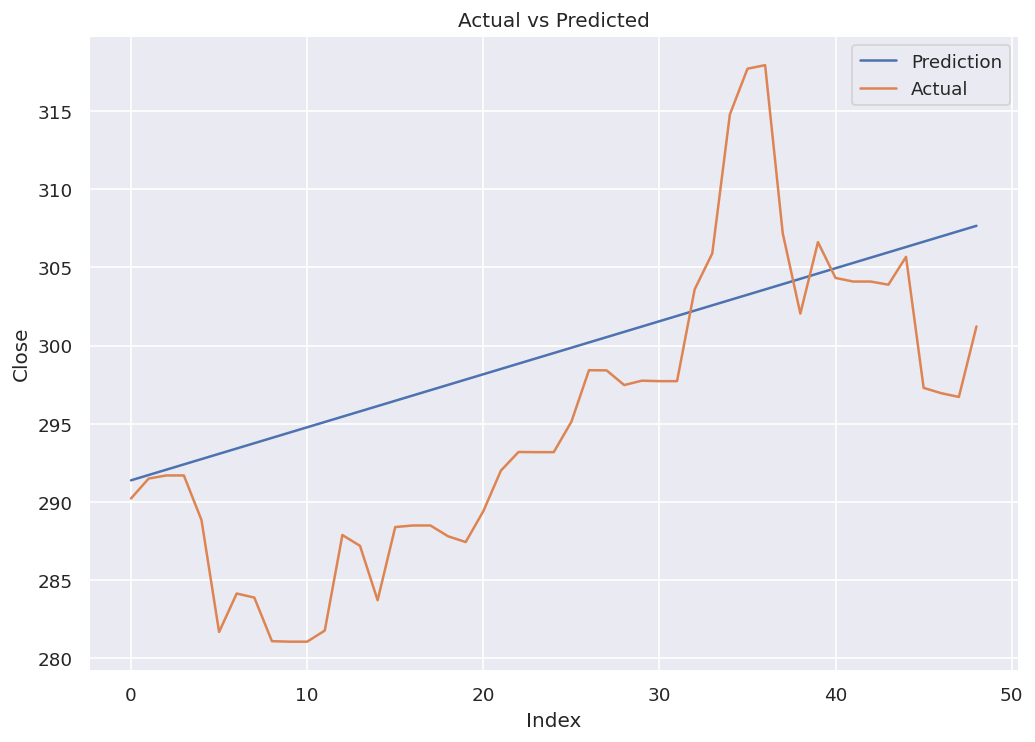

In [60]:
# Forecasting algorithm
input_ts_algo = 'auto_arima'
input_seasonality = 1
auto_arima = train_and_evaluate_model(input_ts_algo)

auto_sarima
------------- Auto SARIMA --------------- 

 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=1664.897, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=1665.861, Time=0.09 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=1665.530, Time=0.22 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=1666.061, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=1667.222, Time=0.44 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=1667.178, Time=0.33 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=1664.786, Time=0.26 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=1666.555, Time=0.34 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=1668.062, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=1665.717, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=1666.554, Time=0.14 sec
 ARIMA(0,1,1)(0,0,2)[5] intercept   : AIC=1666.552, Time=0.30 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=1666.764, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=1668.007, Time=0.32 sec
 ARIMA(0,1,1)(1,0,2)

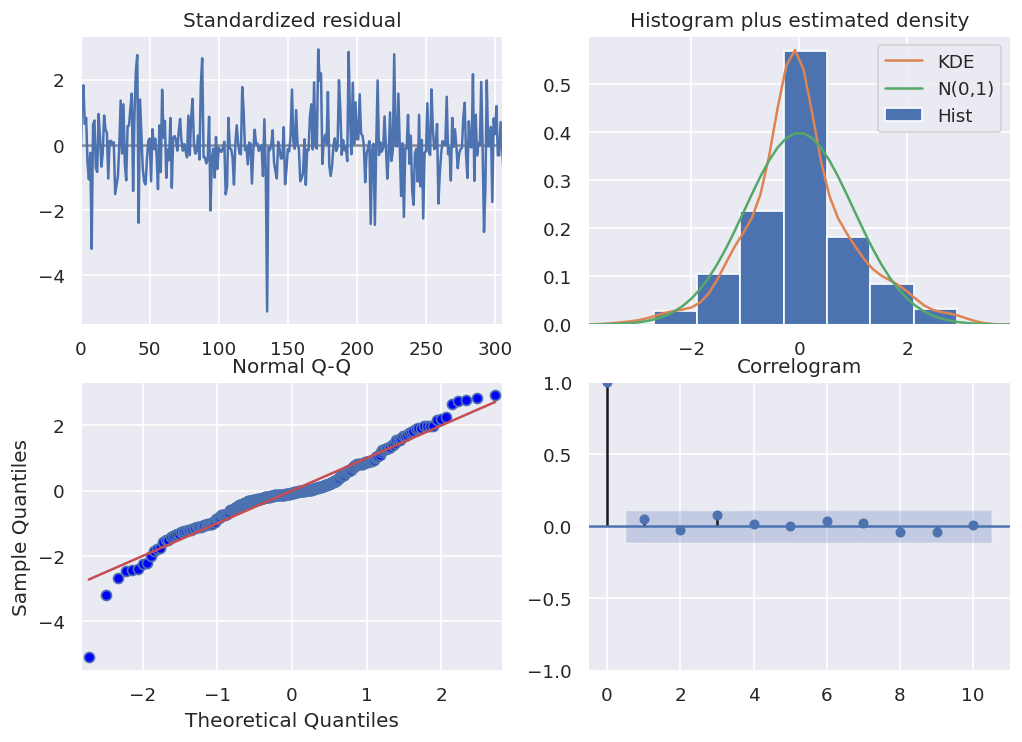

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  2.160639368644089
MAE  :  6.327245120983126
RMSE  :  7.704300418314716
R2 Score  :  0.32396528232084043
Durbin Watson Score :  0.19288630356610398


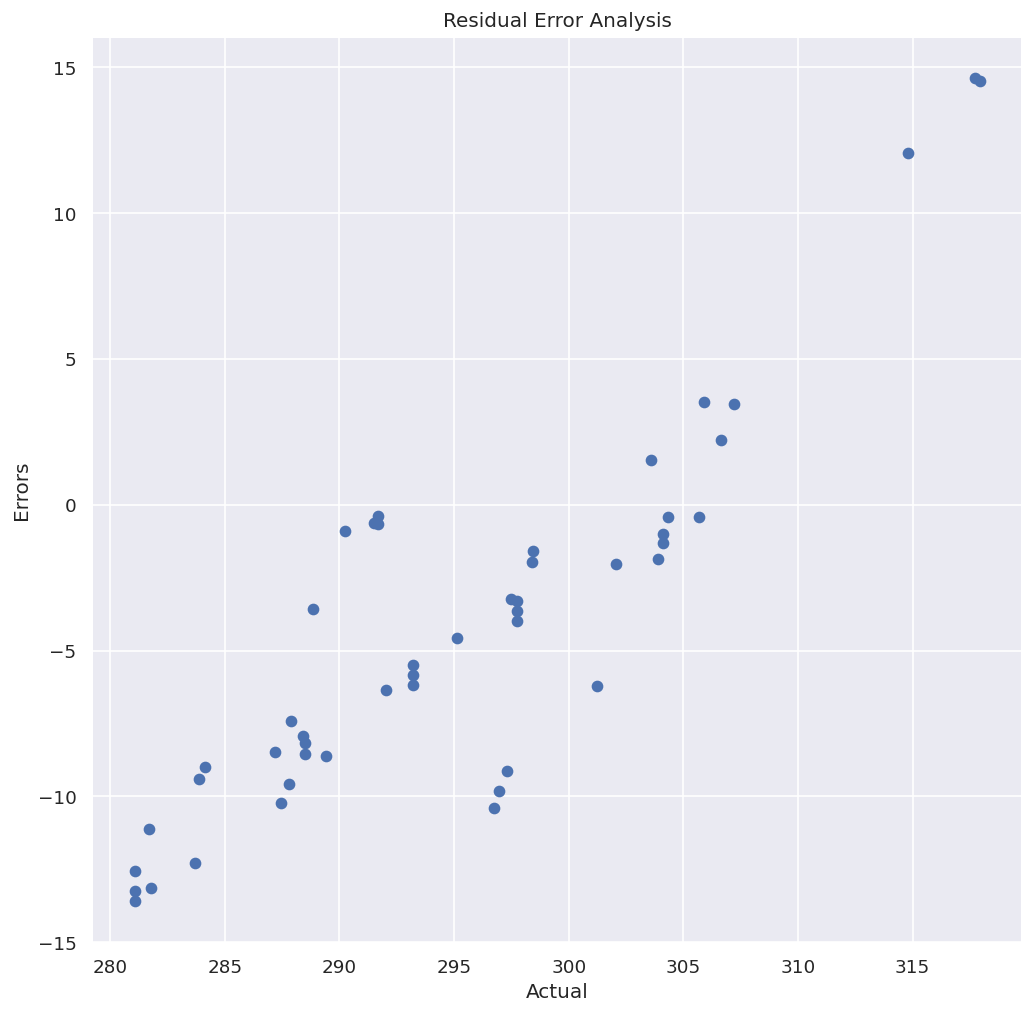

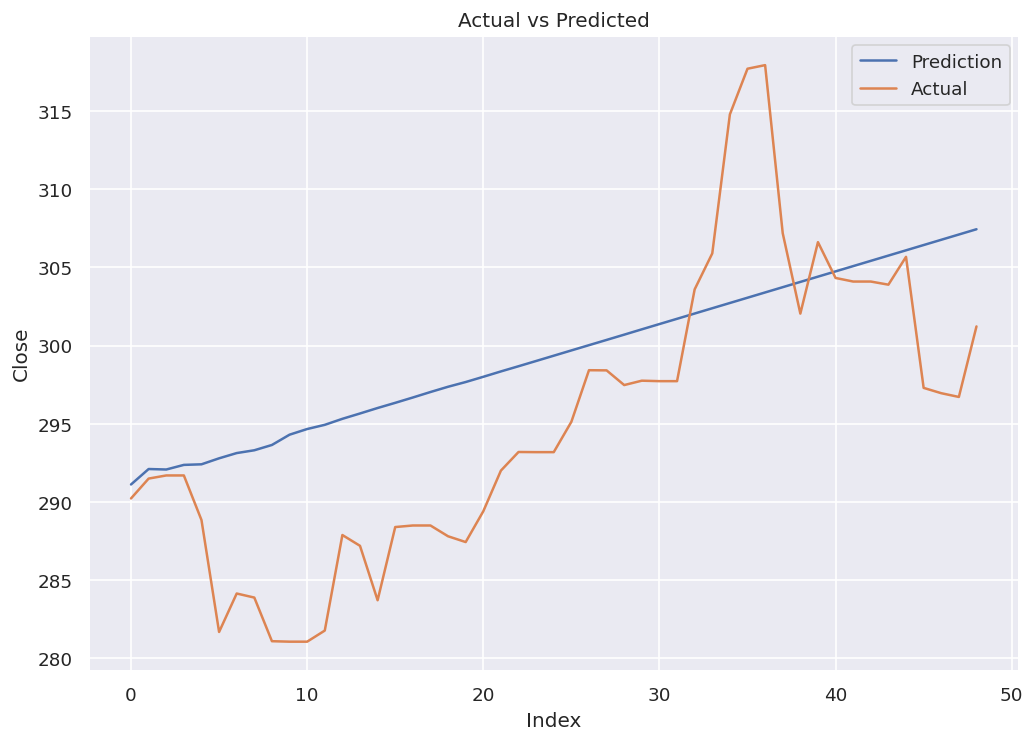

In [61]:
# Forecasting algorithm
input_ts_algo = 'auto_sarima'
input_seasonality = 5
auto_sarima = train_and_evaluate_model(input_ts_algo)

simple_exponential_smoothing
------------- Simple Exponential Smoothing --------------- 

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  308
Model:             SimpleExpSmoothing   SSE                           8973.965
Optimized:                      False   AIC                           1042.571
Trend:                           None   BIC                           1050.031
Seasonal:                        None   AICC                          1042.703
Seasonal Periods:                None   Date:                 Wed, 26 May 2021
Box-Cox:                        False   Time:                         07:56:23
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



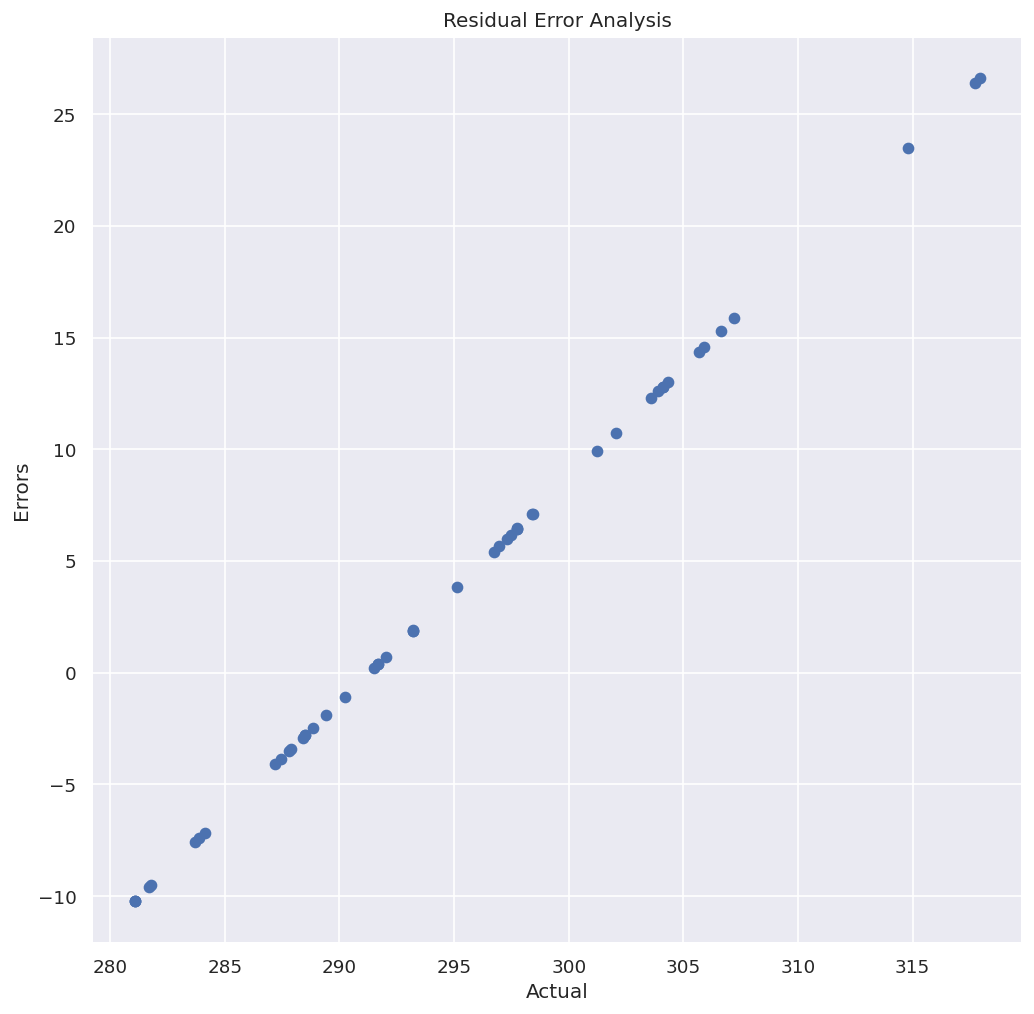

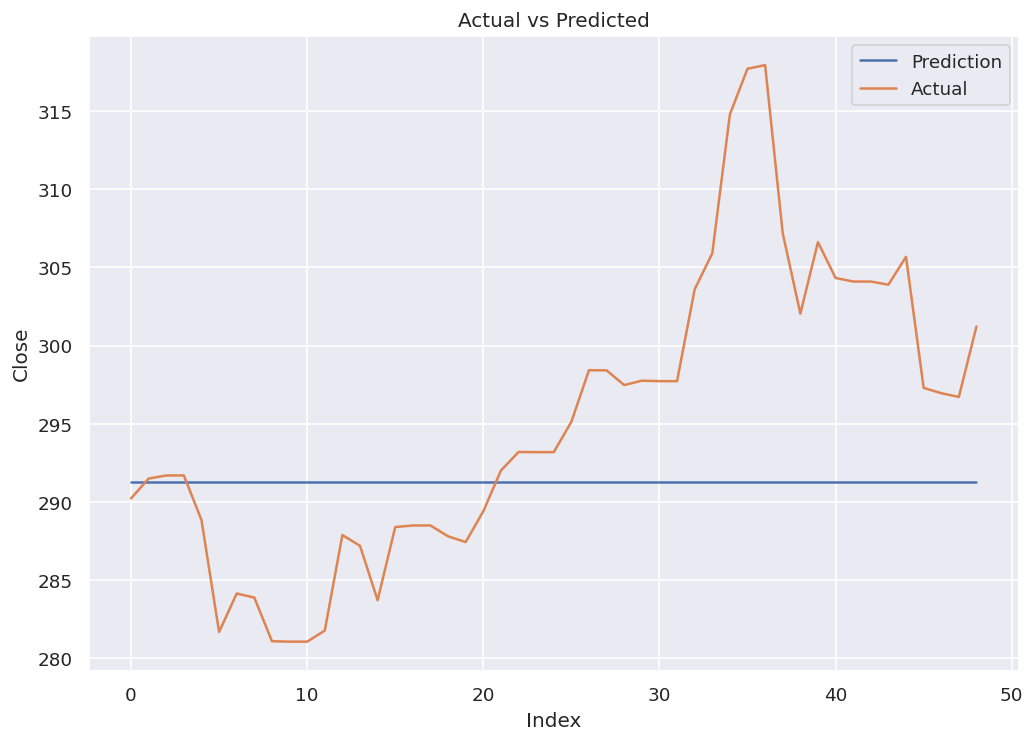

In [62]:
# Forecasting algorithm
input_ts_algo = 'simple_exponential_smoothing'
simple_exponential_smoothing = train_and_evaluate_model(input_ts_algo)

double_exponential_smoothing
------------- double_exponential_smoothing --------------- 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                           4020.089
Optimized:                         True   AIC                            799.240
Trend:                         Additive   BIC                            814.160
Seasonal:                          None   AICC                           799.519
Seasonal Periods:                  None   Date:                 Wed, 26 May 2021
Box-Cox:                          False   Time:                         07:56:24
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level        

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



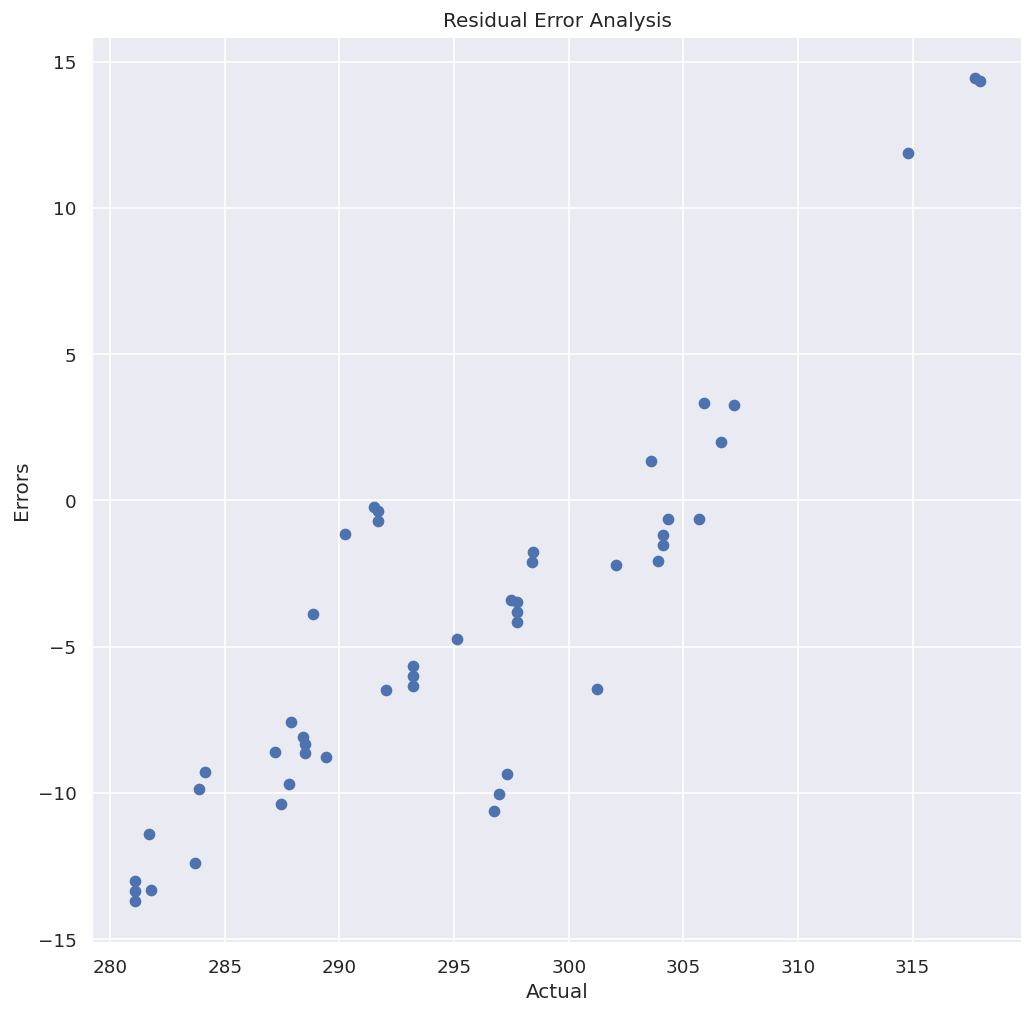

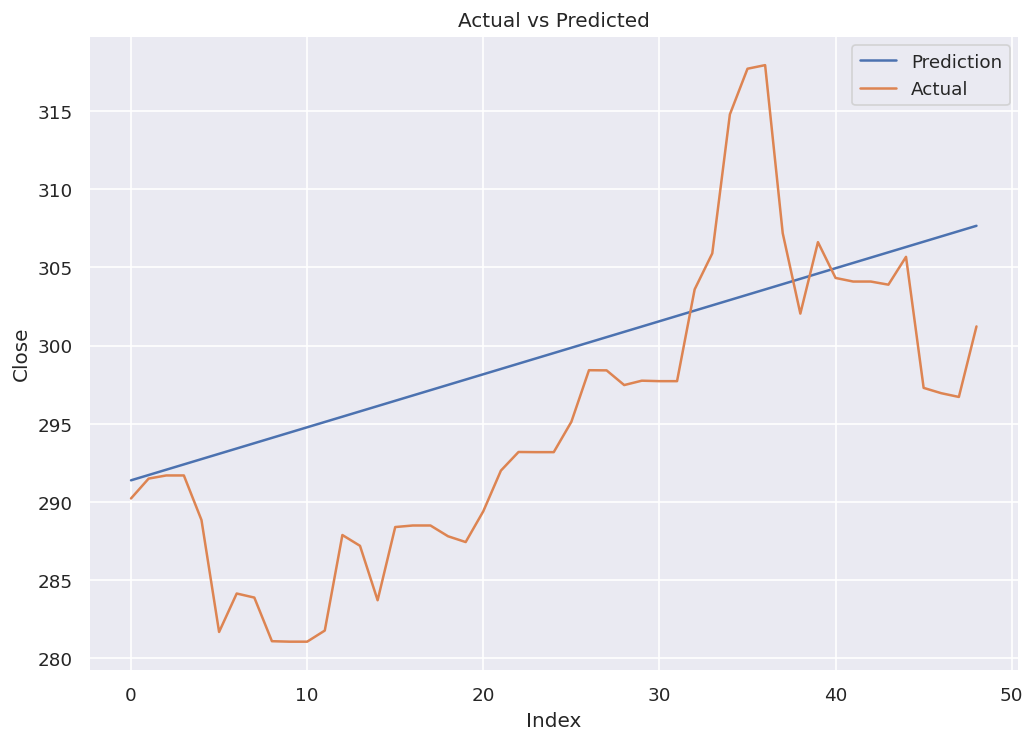

In [63]:
# Forecasting algorithm
input_ts_algo = 'double_exponential_smoothing'
double_exponential_smoothing = train_and_evaluate_model(input_ts_algo, type_='add')

holt_winters
------------- Holt Winters --------------- 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                           3957.192
Optimized:                         True   AIC                            804.383
Trend:                         Additive   BIC                            837.953
Seasonal:                      Additive   AICC                           805.274
Seasonal Periods:                     5   Date:                 Wed, 26 May 2021
Box-Cox:                          False   Time:                         07:56:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000          

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



Durbin Watson Score :  0.18308298549532162


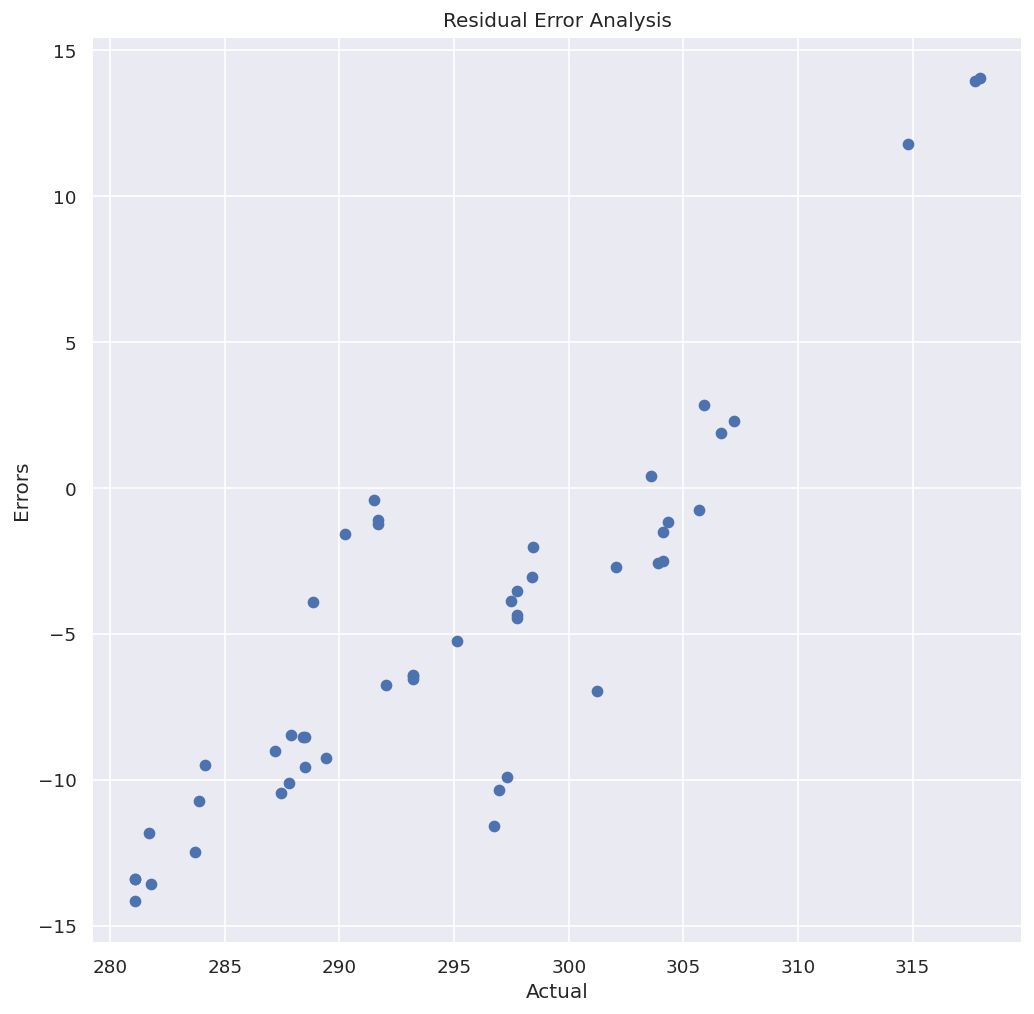

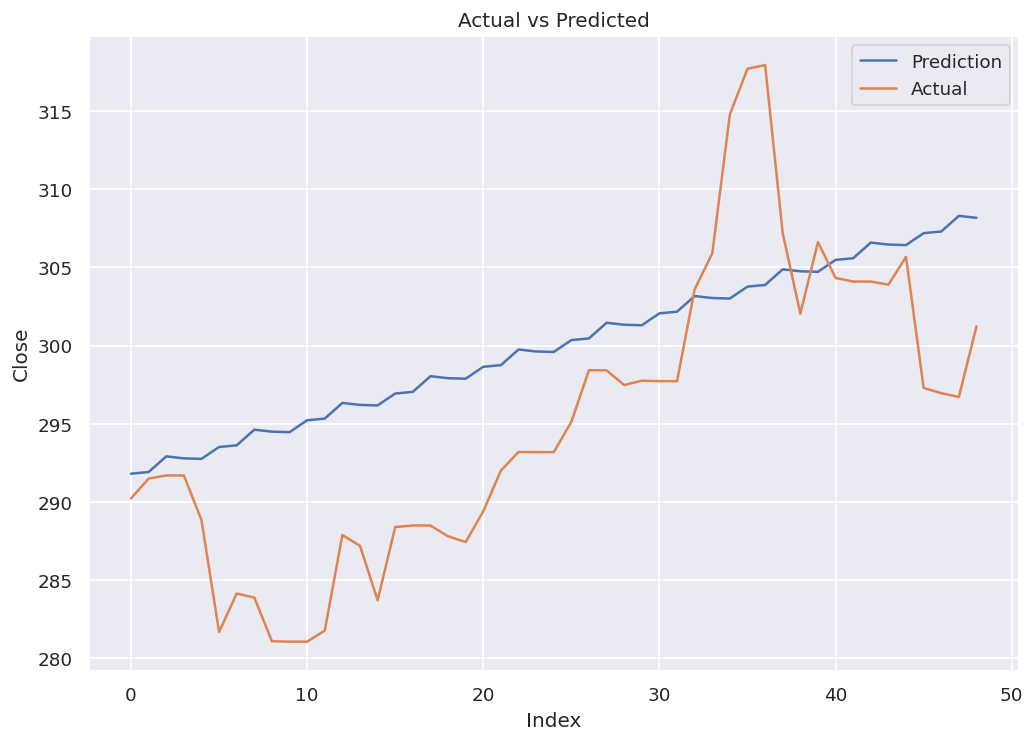

In [64]:
# Forecasting algorithm
input_seasonality = 5
input_ts_algo = 'holt_winters'
holt_winters = train_and_evaluate_model(input_ts_algo, type_='add')

### 4.11. Compare models

In [192]:
results = pd.DataFrame({
    'auto_arima': auto_arima,
    'auto_sarima': auto_sarima,
    'simple_exponential_smoothing': simple_exponential_smoothing,
    'double_exponential_smoothing': double_exponential_smoothing,
    'holt_winters': holt_winters
              })
results

auto_arima  auto_sarima  simple_exponential_smoothing  \
MAPE                   2.203311     2.160639                      2.651404   
RMSE                   7.814215     7.704300                     10.124945   
MAE                    6.450291     6.327245                      7.951059   
R2 Score               0.304538     0.323965                     -0.167583   
Durbin Watson Score    0.188198     0.192886                      0.112485   

                     double_exponential_smoothing  holt_winters  
MAPE                                     2.203311      2.307885  
RMSE                                     7.814215      8.065159  
MAE                                      6.450291      6.753499  
R2 Score                                 0.304538      0.259153  
Durbin Watson Score                      0.188198      0.183083

In [58]:
print(auto_arima)

None


__Step's coclusion__

Analysis of 5 classic models for analyzing time data for two months shows that the models generally cope with capturing the main trend, but they absolutely cannot capture fluctuations during the selected two months.

I suppose that this is due to the fact that classical models try to decompose the time series into trend, season and errors, and since all the charts show that seasonality is not visible in the data, the model was able to restore only the trend.

In any case, we got the border for comparison, then other methods will be applied.

## 5.0 Classic ML with feature engineering (normal or tsfresh)

### 5.1 Usual linear regression with default feature engineering

In [89]:
scaler = StandardScaler()

# for time-series cross-validation set 5 folds 
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [207]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())
    
def prepareData(series, lag_start, lag_end, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

    return X_train, X_test, y_train, y_test

In [208]:
def timeseries_train_test_split(X, y):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    start_index = df[df[input_date_variable] == '2020-04-01'].index[0]
    test_index = df[df[input_date_variable] == '2021-04-01'].index[0]

    X_train = X.loc['2020-04-01':'2021-04-01']
    y_train = y.loc['2020-04-01':'2021-04-01']
    X_test = X.loc['2021-04-01':]
    y_test = y.loc['2021-04-01':]
    
    return X_train, X_test, y_train, y_test

In [209]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [210]:
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=20, target_encoding=False)

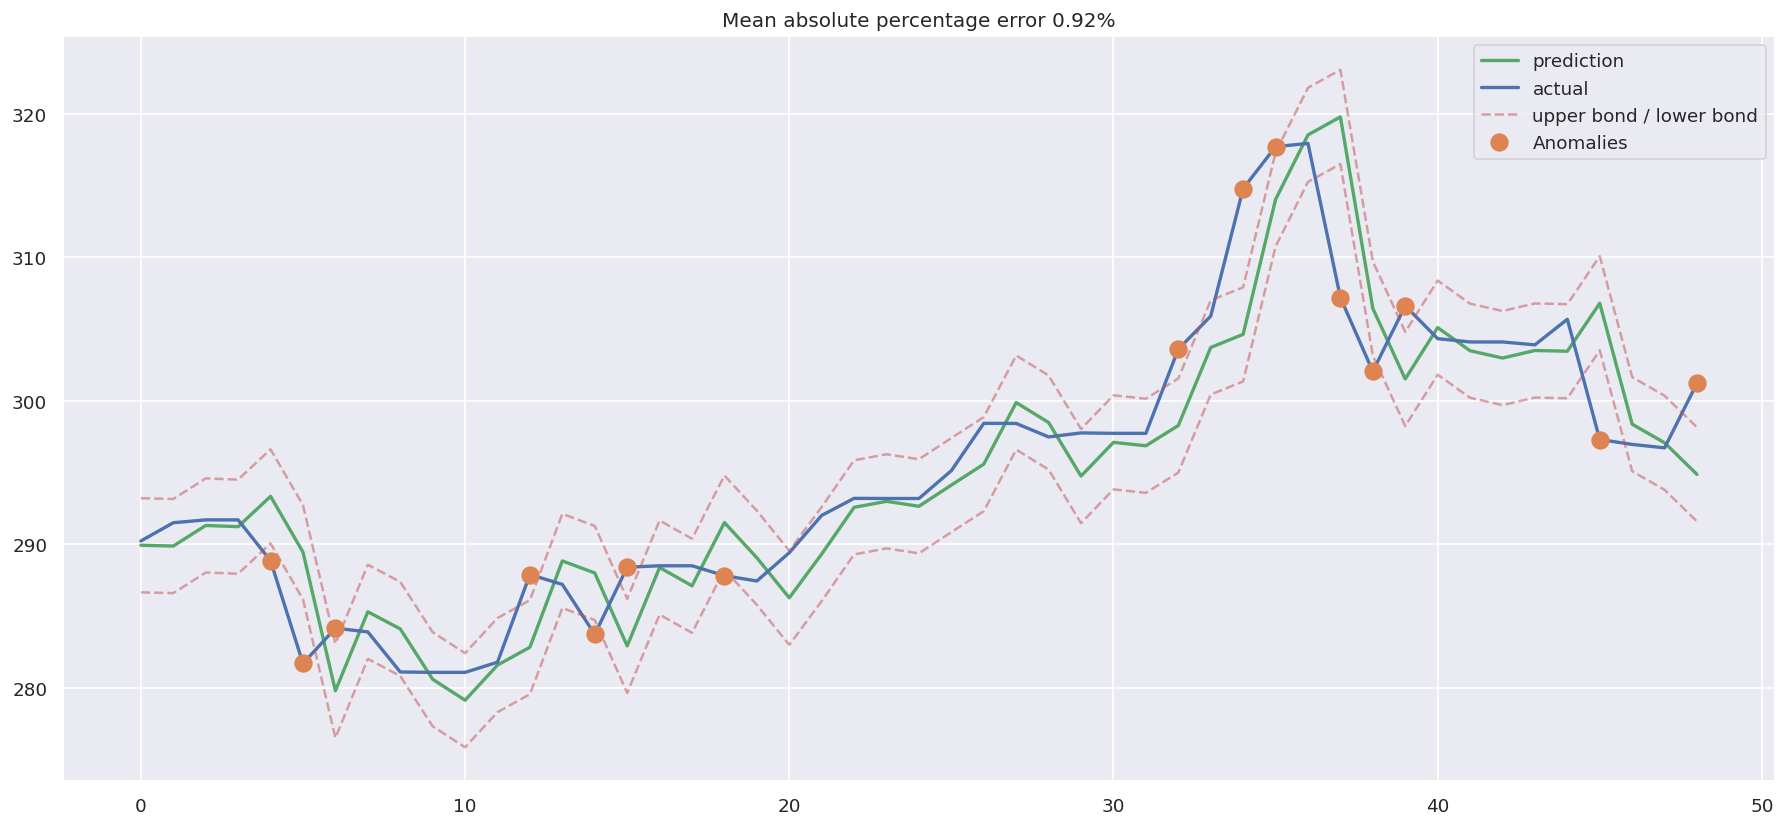

In [211]:
data = df.set_index(df[input_date_variable])[input_target_variable]
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=30, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)

------------- Model Evaluations --------------- 

MAPE :  0.9256078113807533
MAE  :  2.745291170464798
RMSE  :  3.9045773099009864
R2 Score  :  0.8263596575159405
Durbin Watson Score :  1.7219562961360273


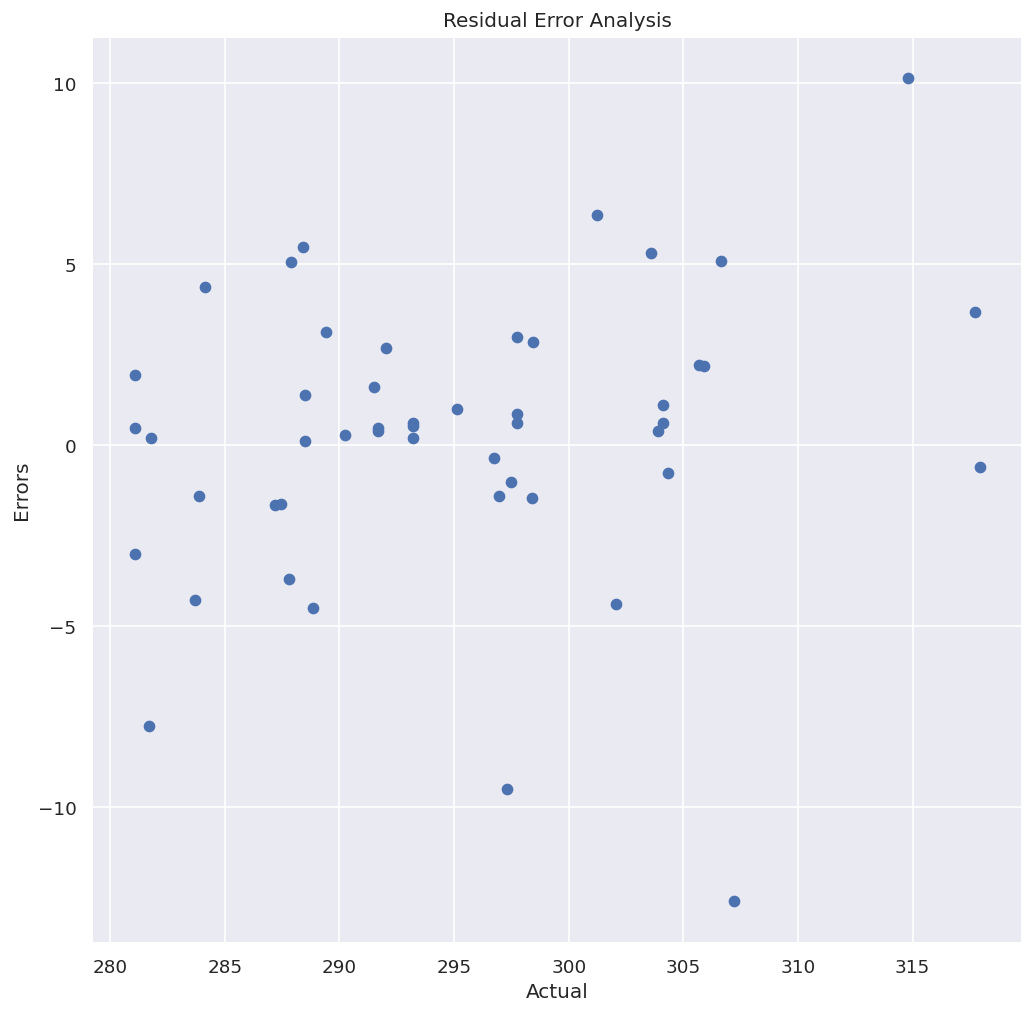

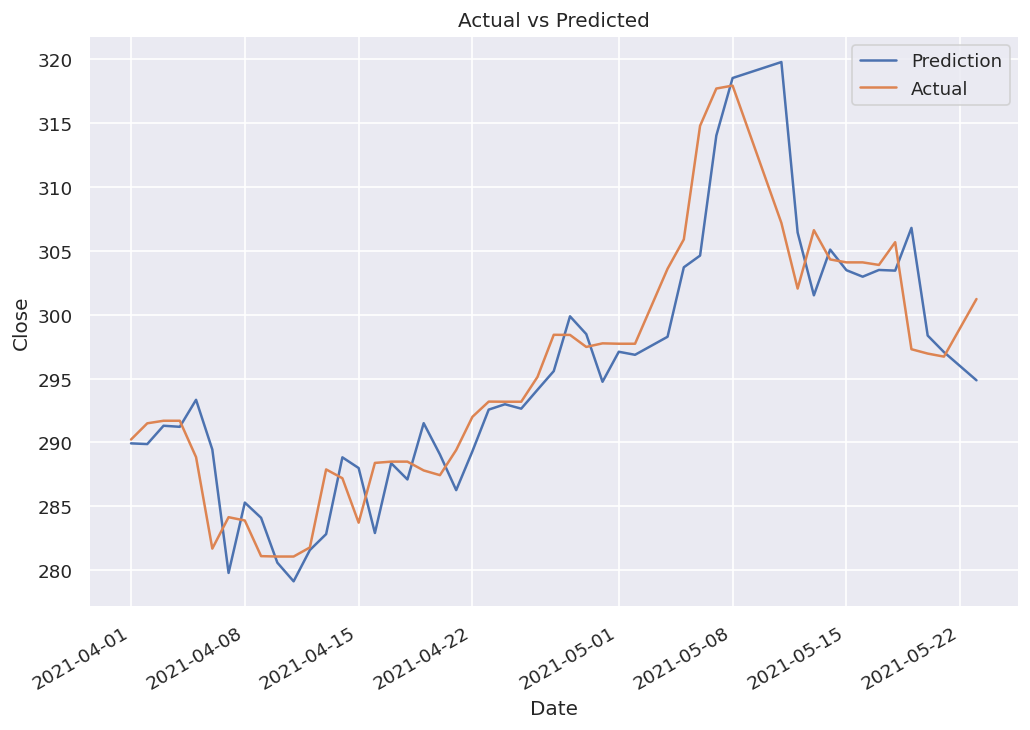

In [212]:
predictions = pd.Series(lr.predict(X_test_scaled), index=y_test.index)
actuals = pd.Series(y_test, index=y_test.index)
lr_results = evaluate_model(actuals, predictions, input_target_variable = input_target_variable)

In [213]:
results['Linear regression with feature engineering'] = pd.Series(lr_results)
results

auto_arima  auto_sarima  simple_exponential_smoothing  \
MAPE                   2.203311     2.160639                      2.651404   
RMSE                   7.814215     7.704300                     10.124945   
MAE                    6.450291     6.327245                      7.951059   
R2 Score               0.304538     0.323965                     -0.167583   
Durbin Watson Score    0.188198     0.192886                      0.112485   

                     double_exponential_smoothing  holt_winters  \
MAPE                                     2.203311      2.307885   
RMSE                                     7.814215      8.065159   
MAE                                      6.450291      6.753499   
R2 Score                                 0.304538      0.259153   
Durbin Watson Score                      0.188198      0.183083   

                     Linear regression with feature engineering  
MAPE                                                   0.925608  
RMSE                                                   3.904577  
MAE                                                    2.745291  
R2 Score                                               0.826360  
Durbin Watson Score                                    1.721956

__Step's coclusion__

Linear regression with feature engeneering gives much better performance.

### 5.3 tsfresh feature engeneering

In [221]:
df['Symbols'] = 'Sber'

In [223]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
df_rolled = roll_time_series(df[['Date', 'Close', 'Symbols']], column_id="Symbols", column_sort="Date",
                             max_timeshift=20, min_timeshift=5)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:456: UserWarning:

Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.

Rolling: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


In [224]:
df_rolled[df_rolled["id"] == ("Sber", pd.to_datetime("2020-07-14"))]

Date   Close Symbols                           id
0 2018-05-23  221.00    Sber  (Sber, 2018-05-30 00:00:00)
1 2018-05-24  222.01    Sber  (Sber, 2018-05-30 00:00:00)
2 2018-05-25  220.00    Sber  (Sber, 2018-05-30 00:00:00)
3 2018-05-28  220.90    Sber  (Sber, 2018-05-30 00:00:00)
4 2018-05-29  219.00    Sber  (Sber, 2018-05-30 00:00:00)

In [229]:
len(df)

826

In [228]:
df_rolled["id"].nunique()

821

In [230]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="Date", column_value="Close", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 5/5 [00:48<00:00,  9.70s/it]


In [231]:
X.head()

Close__variance_larger_than_standard_deviation  \
Sber 2018-05-30                                             0.0   
     2018-05-31                                             1.0   
     2018-06-01                                             1.0   
     2018-06-04                                             1.0   
     2018-06-05                                             1.0   

                 Close__has_duplicate_max  Close__has_duplicate_min  \
Sber 2018-05-30                       0.0                       0.0   
     2018-05-31                       0.0                       0.0   
     2018-06-01                       0.0                       0.0   
     2018-06-04                       0.0                       0.0   
     2018-06-05                       0.0                       0.0   

                 Close__has_duplicate  Close__sum_values  Close__abs_energy  \
Sber 2018-05-30                   0.0            1323.92        292132.6702   
     2018-05-31                   0.0            1546.28        341576.6398   
     2018-06-01                   1.0            1766.28        389976.6398   
     2018-06-04                   1.0            1986.28        438376.6398   
     2018-06-05                   1.0            2201.84        484842.7534   

                 Close__mean_abs_change  Close__mean_change  \
Sber 2018-05-30                1.566000            0.002000   
     2018-05-31                1.530000            0.226667   
     2018-06-01                1.648571           -0.142857   
     2018-06-04                1.442500           -0.125000   
     2018-06-05                1.775556           -0.604444   

                 Close__mean_second_derivative_central  Close__median  \
Sber 2018-05-30                               0.125000         220.95   
     2018-05-31                               0.034000         221.00   
     2018-06-01                              -0.280833         220.95   
     2018-06-04                              -0.072143         220.90   
     2018-06-05                              -0.340625         220.45   

                 Close__mean  Close__length  Close__standard_deviation  \
Sber 2018-05-30   220.653333            6.0                   0.940668   
     2018-05-31   220.897143            7.0                   1.055986   
     2018-06-01   220.785000            8.0                   1.031383   
     2018-06-04   220.697778            9.0                   1.003204   
     2018-06-05   220.184000           10.0                   1.811487   

                 Close__variation_coefficient  Close__variance  \
Sber 2018-05-30                      0.004263         0.884856   
     2018-05-31                      0.004780         1.115106   
     2018-06-01                      0.004671         1.063750   
     2018-06-04                      0.004546         1.006417   
     2018-06-05                      0.008227         3.281484   

                 Close__skewness  Close__kurtosis  Close__root_mean_square  \
Sber 2018-05-30        -0.602992         0.626730               220.655338   
     2018-05-31        -0.477873         0.036010               220.899667   
     2018-06-01        -0.126012        -0.417745               220.787409   
     2018-06-04         0.134143        -0.468002               220.700058   
     2018-06-05        -1.649407         3.768340               220.191452   

                 Close__absolute_sum_of_changes  \
Sber 2018-05-30                            7.83   
     2018-05-31                            9.18   
     2018-06-01                           11.54   
     2018-06-04                           11.54   
     2018-06-05                           15.98   

                 Close__longest_strike_below_mean  \
Sber 2018-05-30                               1.0   
     2018-05-31                               1.0   
     2018-06-01                               1.0   
     2018-06-04                               2.0   
     2018-0

In [232]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

Close__variance_larger_than_standard_deviation  \
last_date                                                    
2018-05-30                                             0.0   
2018-05-31                                             1.0   
2018-06-01                                             1.0   
2018-06-04                                             1.0   
2018-06-05                                             1.0   

            Close__has_duplicate_max  Close__has_duplicate_min  \
last_date                                                        
2018-05-30                       0.0                       0.0   
2018-05-31                       0.0                       0.0   
2018-06-01                       0.0                       0.0   
2018-06-04                       0.0                       0.0   
2018-06-05                       0.0                       0.0   

            Close__has_duplicate  Close__sum_values  Close__abs_energy  \
last_date                                                                
2018-05-30                   0.0            1323.92        292132.6702   
2018-05-31                   0.0            1546.28        341576.6398   
2018-06-01                   1.0            1766.28        389976.6398   
2018-06-04                   1.0            1986.28        438376.6398   
2018-06-05                   1.0            2201.84        484842.7534   

            Close__mean_abs_change  Close__mean_change  \
last_date                                                
2018-05-30                1.566000            0.002000   
2018-05-31                1.530000            0.226667   
2018-06-01                1.648571           -0.142857   
2018-06-04                1.442500           -0.125000   
2018-06-05                1.775556           -0.604444   

            Close__mean_second_derivative_central  Close__median  Close__mean  \
last_date                                                                       
2018-05-30                               0.125000         220.95   220.653333   
2018-05-31                               0.034000         221.00   220.897143   
2018-06-01                              -0.280833         220.95   220.785000   
2018-06-04                              -0.072143         220.90   220.697778   
2018-06-05                              -0.340625         220.45   220.184000   

            Close__length  Close__standard_deviation  \
last_date                                              
2018-05-30            6.0                   0.940668   
2018-05-31            7.0                   1.055986   
2018-06-01            8.0                   1.031383   
2018-06-04            9.0                   1.003204   
2018-06-05           10.0                   1.811487   

            Close__variation_coefficient  Close__variance  Close__skewness  \
last_date                                                                    
2018-05-30                      0.004263         0.884856        -0.602992   
2018-05-31                      0.004780         1.115106        -0.477873   
2018-06-01                      0.004671         1.063750        -0.126012   
2018-06-04                      0.004546         1.006417         0.134143   
2018-06-05                      0.008227         3.281484        -1.649407   

            Close__kurtosis  Close__root_mean_square  \
last_date                                              
2018-05-30         0.626730               220.655338   
2018-05-31         0.036010               220.899667   
2018-06-01        -0.417745               220.787409   
2018-06-04        -0.468002               220.700058   
2018-06-05         3.768340               220.191452   

            Close__absolute_sum_of_changes  Close__longest_strike_below_mean  \
last_date                                                                      
2018-05-30                            7.83                               1.0   
2018-05-31                            9.18     

In [ ]:
y = df_melted.set_index("date").sort_index().high.shift(-1)

In [ ]:
X_train = X[:"2018"]
X_test = X["2019":]

y_train = y[:"2018"]
y_test = y["2019":]

In [ ]:
X_train_selected = select_features(X_train, y_train)

In [ ]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train)

In [ ]:

X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

__Step's coclusion__

## 6.0 Prophet library

Prophet assumptions:
* hourly, daily, or weekly observations with at least a few months (preferably a year) of history
* strong multiple “human-scale” seasonalities: day of week and time of year
important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
* a reasonable number of missing observations or large outliers
* historical trend changes, for instance due to product launches or logging changes
* trends that are non-linear growth curves, where a trend hits a natural limit or saturates

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

**Trend**

The Prophet library implements two possible trend models for $g(t)$.

The first one is called *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

where:
* $C$ is the carrying capacity (that is the curve's maximum value).
* $k$ is the growth rate (which represents "the steepness" of the curve).
* $m$ is an offset parameter.

This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. One of the typical examples would be representing the growth of the audience of an application or a website.

Actually, $C$ and $k$ are not necessarily constants and may vary over time. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data. 

Also, Prophet allows analysts to manually set changepoints of the growth rate and capacity values at different points in time. For instance, analysts may have insights about dates of past releases that prominently influenced some key product indicators.

The second trend model is a simple *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality.

Weekly seasonal data is modeled with dummy variables. Six new variables are added: `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, which take values 0 or 1 depending on the day of the week. The feature `sunday` is not added because it would be a linear combination of the other days of the week, and this fact would have an adverse effect on the model.

Yearly seasonality model in Prophet relies on Fourier series.

Since [version 0.2](https://github.com/facebook/prophet) you can also use *sub-daily time series* and make *sub-daily forecasts* as well as employ the new *daily seasonality* feature.

Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In [ ]:
prophet_example = df[['date', 'value']]
prophet_example.columns = ['ds', 'y']
prophet_example.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [ ]:
m = Prophet()
m.fit(prophet_example)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=100)

In [ ]:
forecast = m.predict(future)
forecast.tail(n=3)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
301 2008-09-07  3.533557    3.372073    3.523177     3.533404     3.533705   
302 2008-09-08  3.533954    3.360795    3.519438     3.533795     3.534105   
303 2008-09-09  3.534351    3.359072    3.517029     3.534188     3.534507   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
301       -0.086288             -0.086288             -0.086288 -0.086288   
302       -0.094090             -0.094090             -0.094090 -0.094090   
303       -0.099677             -0.099677             -0.099677 -0.099677   

     yearly_lower  yearly_upper  multiplicative_terms  \
301     -0.086288     -0.086288                   0.0   
302     -0.094090     -0.094090                   0.0   
303     -0.099677     -0.099677                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
301                         0.0                         0.0  3.447269  
302                         0.0                         0.0  3.439864  
303                         0.0                         0.0  3.434674

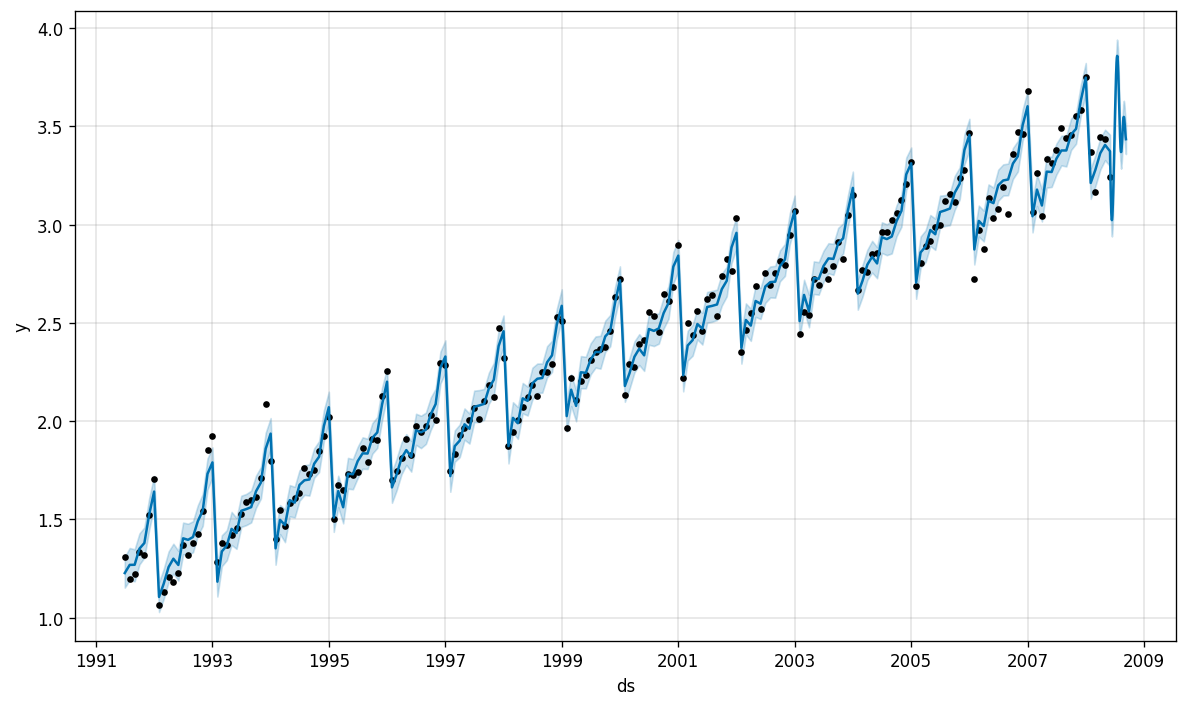

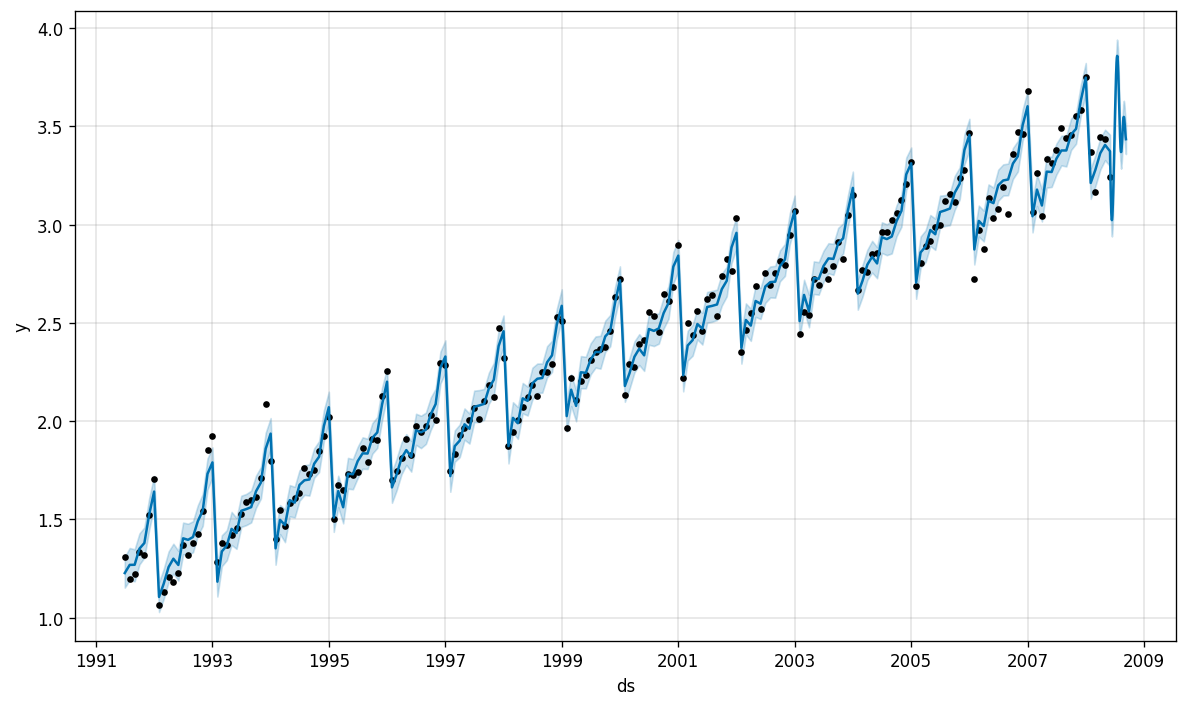

In [ ]:
m.plot(forecast)

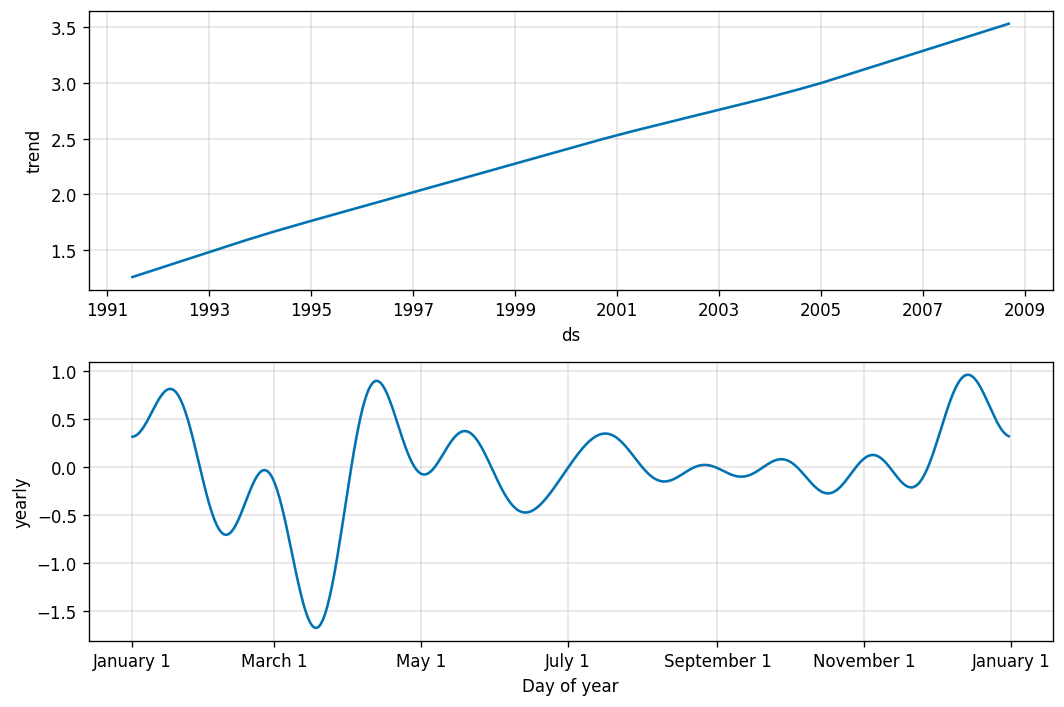

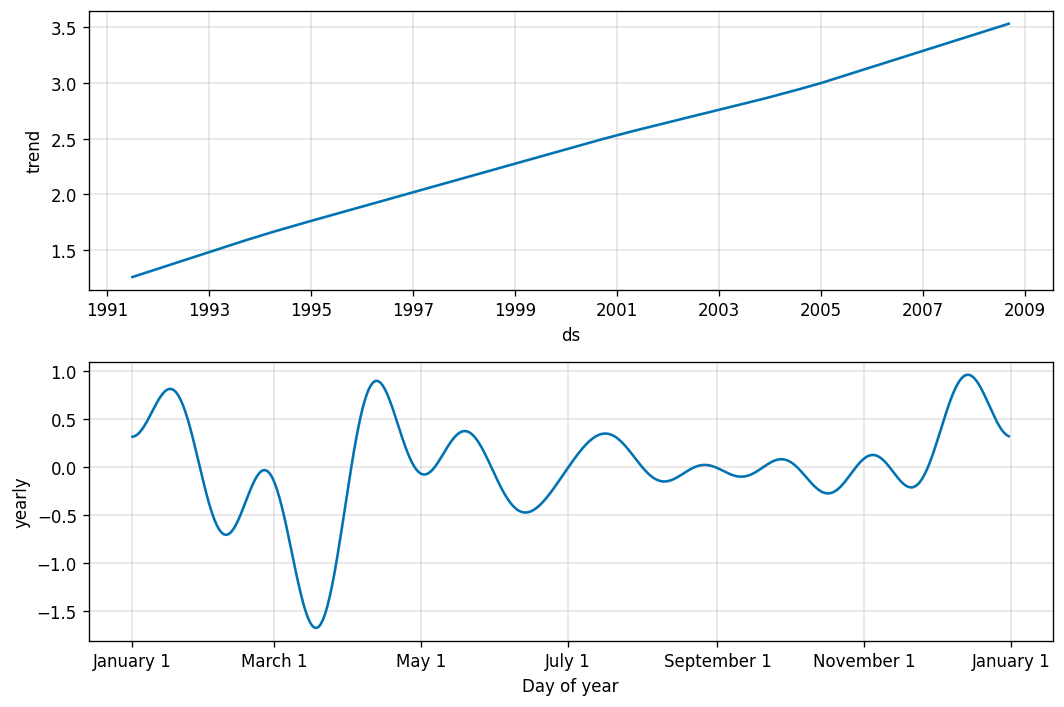

In [ ]:
m.plot_components(forecast)

In [ ]:
C_widget = pn.widgets.DiscreteSlider(name='Carrying capacity', options=[10, 20, 30, 40, 50], value=20)
k_widget = pn.widgets.DiscreteSlider(name='Growth rate', options=[0.01, 0.1, 0.5, 1, 2, 10], value=0.1)
@pn.depends(C_widget, k_widget)
def plot(C_widget, k_widget):
    C = C_widget
    k = k_widget
    m = 0
    t = range(50)
    g = []
    for i in t:
        g.append(C/(1+np.exp(-k*(i-m))))
        
    return pd.DataFrame({'time':t, 'value':g}).hvplot('time','value', ylim = (0,50))

pn.Column(C_widget, k_widget, plot).embed()

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
df_cv = cross_validation(m, initial='400 days', period='90 days', horizon = '180 days')
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 63 forecasts with cutoffs between 1992-08-24 00:00:00 and 2007-12-04 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


horizon       mse      rmse       mae      mape     mdape  coverage
0    18 days  0.231259  0.480894  0.160974  0.092553  0.014845  0.729730
1    19 days  0.232406  0.482085  0.167455  0.095762  0.017184  0.702703
2    21 days  0.232772  0.482465  0.169680  0.096552  0.017184  0.662162
3    22 days  0.232780  0.482473  0.169785  0.096551  0.020233  0.675676
4    23 days  0.228364  0.477874  0.169809  0.093962  0.023607  0.630631
5    24 days  0.147476  0.384026  0.125442  0.065491  0.022273  0.666667
6    25 days  0.076990  0.277470  0.093233  0.046653  0.021322  0.684685
7    26 days  0.006777  0.082321  0.063473  0.028601  0.021322  0.675676
8    27 days  0.005637  0.075081  0.059872  0.025996  0.021872  0.693694
9    28 days  0.005097  0.071397  0.057668  0.024381  0.021322  0.675676
10   29 days  0.005119  0.071548  0.057832  0.024472  0.021322  0.675676
11   30 days  0.005595  0.074797  0.061491  0.026335  0.022273  0.648649
12   31 days  0.005533  0.074381  0.061086  0.025911  0.022273  0.666667
13   32 days  0.005285  0.072697  0.058533  0.024614  0.021872  0.702703
14   33 days  0.005501  0.074170  0.060180  0.025291  0.022273  0.675676
15   34 days  0.005399  0.073481  0.059462  0.024326  0.022273  0.675676
16   35 days  0.005481  0.074034  0.060330  0.024865  0.022273  0.648649
17   36 days  0.005532  0.074375  0.061037  0.025145  0.022957  0.630631
18   37 days  0.005479  0.074023  0.060892  0.025264  0.022957  0.639640
19   38 days  0.036582  0.191263  0.086764  0.044036  0.022273  0.621622
20   39 days  0.036303  0.190533  0.085477  0.043395  0.022273  0.635135
21   40 days  0.173451  0.416474  0.158431  0.093755  0.022614  0.621622
22   41 days  0.173286  0.416276  0.157502  0.093767  0.022614  0.608108
23   42 days  0.173077  0.416026  0.156221  0.093215  0.022614  0.608108
24   43 days  0.172902  0.415815  0.155297  0.093261  0.022614  0.594595
25   44 days  0.172864  0.415769  0.155140  0.093347  0.022614  0.594595
26   45 days  0.175243  0.418620  0.162090  0.097391  0.022957  0.567568
27   46 days  0.175600  0.419047  0.164805  0.099137  0.025834  0.527027
28   47 days  0.175641  0.419096  0.165517  0.099241  0.025834  0.540541
29   48 days  0.175665  0.419124  0.166829  0.099746  0.026120  0.500000
30   49 days  0.175766  0.419245  0.167459  0.099717  0.026120  0.486486
31   50 days  0.176322  0.419907  0.170685  0.101926  0.026904  0.459459
32   51 days  0.177891  0.421771  0.177275  0.104717  0.029449  0.418919
33   52 days  0.179004  0.423089  0.181634  0.105704  0.029449  0.405405
34   53 days  0.168574  0.410578  0.172602  0.098993  0.029449  0.423423
35   54 days  0.158203  0.397748  0.164369  0.092588  0.029449  0.414414
36   55 days  0.120765  0.347513  0.142775  0.076224  0.031546  0.394595
37   56 days  0.039349  0.198365  0.101725  0.046806  0.030391  0.389189
38   57 days  0.011866  0.108930  0.086556  0.035900  0.029449  0.405405
39   58 days  0.011889  0.109038  0.086977  0.036131  0.029449  0.391892
40   59 days  0.012763  0.112973  0.091023  0.037328  0.031145  0.391892
41   60 days  0.012710  0.112737  0.090020  0.036779  0.031145  0.405405
42   61 days  0.012131  0.110142  0.090626  0.036312  0.032057  0.378378
43   62 days  0.011451  0.107010  0.087931  0.034942  0.031546  0.391892
44   63 days  0.010815  0.103993  0.086186  0.033909  0.031546  0.405405
45   64 days  0.010634  0.103122  0.085014  0.033154  0.031145  0.432432
46   65 days  0.010427  0.102113  0.083549  0.032159  0.029449  0.459459
47   66 days  0.010577  0.102844  0.082913  0.032061  0.029449  0.468468
48   67 days  0.010279  0.101385  0.080791  0.031228  0.028113  0.486486
49   69 days  0.050198  0.224049  0.109623  0.050138  0.028113  0.500000
50   70 days  0.052905  0.230011  0.116350  0.055303  0.028113  0.486486
51   71 days  0.163815  0.404740  0.160350  0.094087  0.024252  0.540541
52   72 days  0.163511  0.404364  0.158606  0.094184  0.023122  0.567568
53   74 days  0.162700  0.403361  0.154072  0.092973  0.019785 

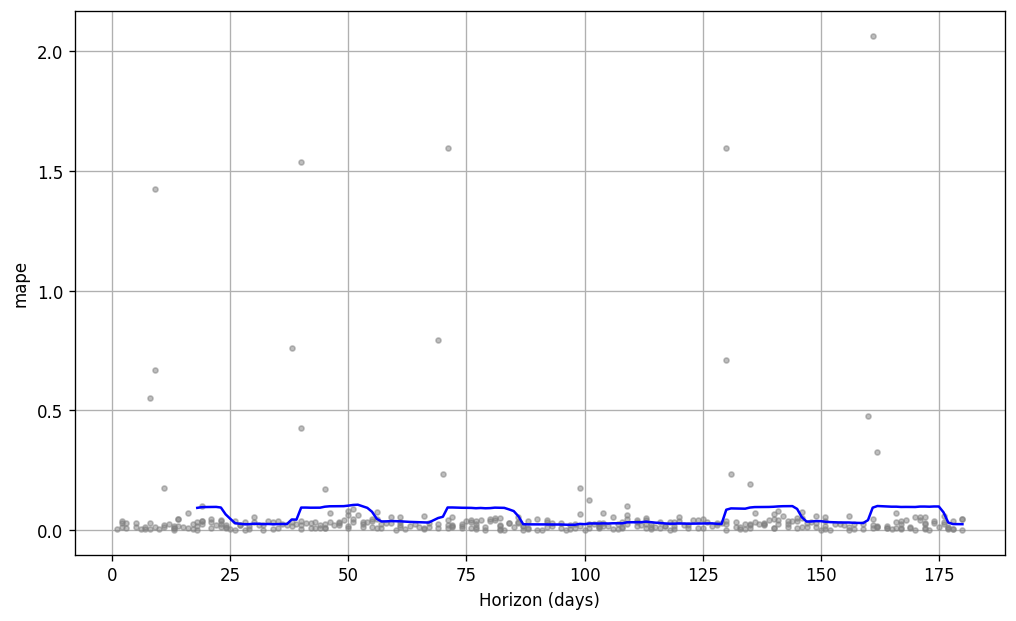

In [ ]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
# ref: https://nbviewer.jupyter.org/github/ryankarlos/prophet/blob/9e6d9548d1caca27af3367819bab10a65da10392/notebooks/diagnostics.ipynb#Hyperparameter-Optimisation
def create_param_combinations(**param_dict):
    param_iter = product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.add_country_holidays(country_name='US')
    m.fit(history_df)
    df_cv = cross_validation(m, initial='400 days', period='90 days', horizon = '180 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                'yearly_seasonality': [5, 10, 20]
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

ValueError: ignored

__Step's coclusion__

## 7.0 GluonTS (deep learning Amazon)

https://ts.gluon.ai/tutorials/forecasting/quick_start_tutorial.html
https://aws.amazon.com/ru/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/
https://otus.ru/nest/post/903/

In [ ]:
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning:

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.



In [ ]:
df.head()

date     value  month_no  year month  id
0 1991-07-01  3.526591         7  1991   Jul   0
1 1991-08-01  3.180891         8  1991   Aug   0
2 1991-09-01  3.252221         9  1991   Sep   0
3 1991-10-01  3.611003        10  1991   Oct   0
4 1991-11-01  3.565869        11  1991   Nov   0

In [ ]:
prediction_length = 30
training_data = ListDataset(
    [{"start": df[input_date_variable][0], "target": df[input_target_variable].iloc[:-30]}],
    freq = "M"
)
#training_data.list_data

In [ ]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    freq="M", 
    prediction_length=prediction_length, 
    trainer=Trainer(epochs=20)
)
predictor = estimator.train(training_data=training_data)


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:04<00:00, 10.05it/s, epoch=1/20, avg_epoch_loss=2.16]

100%|██████████| 50/50 [00:04<00:00, 10.81it/s, epoch=2/20, avg_epoch_loss=1.24]

100%|██████████| 50/50 [00:04<00:00, 10.86it/s, epoch=3/20, avg_epoch_loss=0.991]

100%|██████████| 50/50 [00:04<00:00, 10.86it/s, epoch=4/20, avg_epoch_loss=0.839]

100%|██████████| 50/50 [00:04<00:00, 10.85it/s, epoch=5/20, avg_epoch_loss=0.692]

100%|██████████| 50/50 [00:04<00:00, 10.89it/s, epoch=6/20, avg_epoch_loss=0.608]

100%|██████████| 50/50 [00:04<00:00, 10.78it/s, epoch=7/20, avg_epoch_loss=0.512]

100%|██████████| 50/50 [00:04<00:00, 10.78it/s, epoch=8/20, avg_epoch_loss=0.458]

100%|██████████| 50/50 [00:04<00:00, 10.84it/s, epoch=9/20, avg_epoch_loss=0.372]

100%|██████████| 50/50 [00:04<00:00, 11.00it/s, epoch=10/20, avg_epoch_loss=0.406]

100%|██████████| 50/50 [00:04<00:00, 10.79it/s, epoch=11/20, avg_epoch_loss=0.32]

100%|██████████| 50/50 [00:04<00:00, 10.84it/s, epoch=12/20, avg_epoch_loss=0.287]

100%

ModuleNotFoundError: ignored

In [ ]:
predictor = estimator.train(dataset.train)

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
__Step's coclusion__

## 8.0 Manual Deep learning Model

https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca

In [ ]:
__Step's coclusion__

## 9.0 Compare results

In [ ]:
__Step's coclusion__

## 10.0 Usefull functions

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

